# AML 2023: Assignment 2

Anjan Mondal

MDS202208

In [ ]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)



cpu


# Part1: VAE for FASHIONMNIST

In [ ]:
# Convert vector to image
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x


# Display images, n=max number of images to show
def display_images(in_raw, out_raw, n=1):
    out_raw = out_raw[:n]
    if in_raw is not None:
        in_raw = in_raw[:n]
        in_pic = to_img(in_raw.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.imshow(in_pic[i])
            plt.axis('off')
    out_pic = to_img(out_raw.cpu().data)
    plt.figure(figsize=(18, 6))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(out_pic[i])
        plt.axis('off')
    plt.show()

In [ ]:
# Define data loading step

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, download=True, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 16973085.08it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 267302.24it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5015239.64it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17611971.45it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [ ]:
class VAE(nn.Module):
    def __init__(self, d=50):
        super().__init__()
        self.d = d #latent dimension

        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2) # we have mean and variance, each is d-dim vector
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Tanh()
        )

    def sampler(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, self.d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.sampler(mu, logvar)
        return self.decoder(z), mu, logvar

    def generate(self, N=10):
        z = torch.randn((N, self.d)).to(device)
        gen_img = self.decoder(z)
        return gen_img



def loss_function(x_hat, x, mu, logvar, beta=1):
    #recon_loss = nn.functional.binary_cross_entropy(
    recon_loss = nn.functional.mse_loss(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return recon_loss + beta * KLD

====> Test set loss: 1234.8108


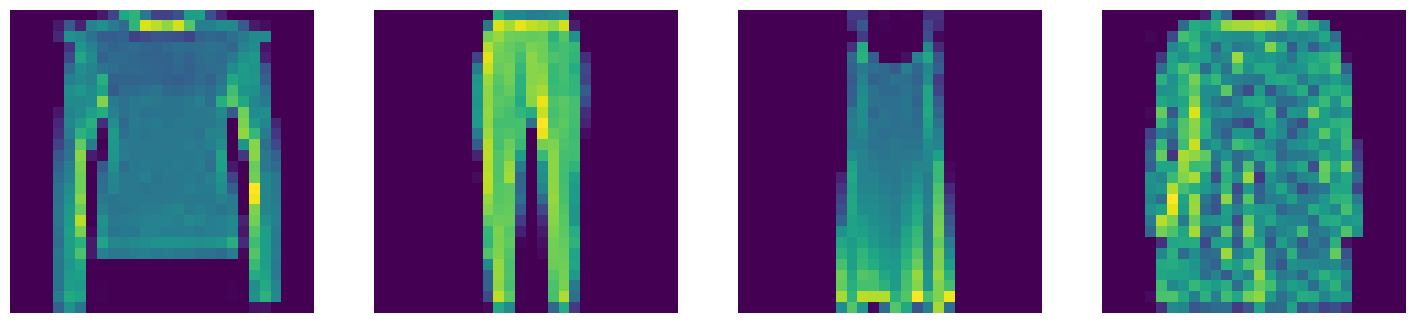

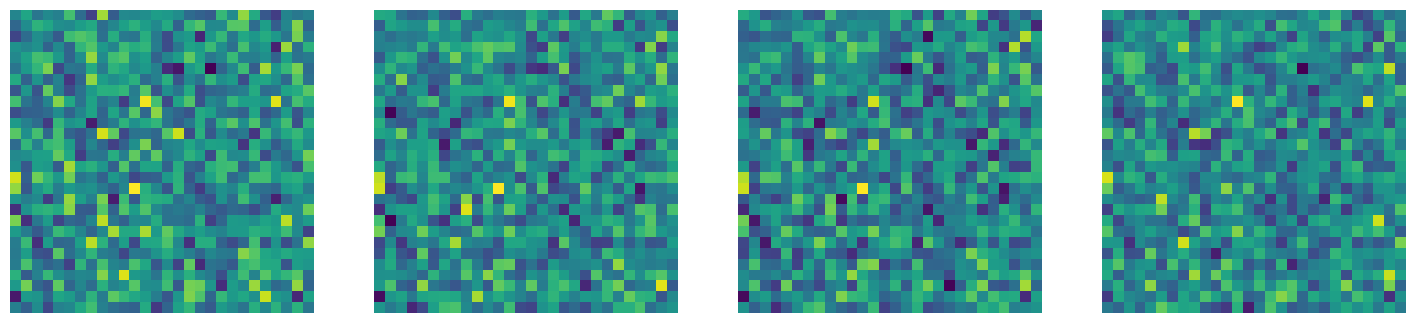

====> Epoch: 1 Average loss: 457.6484
====> Test set loss: 420.4730


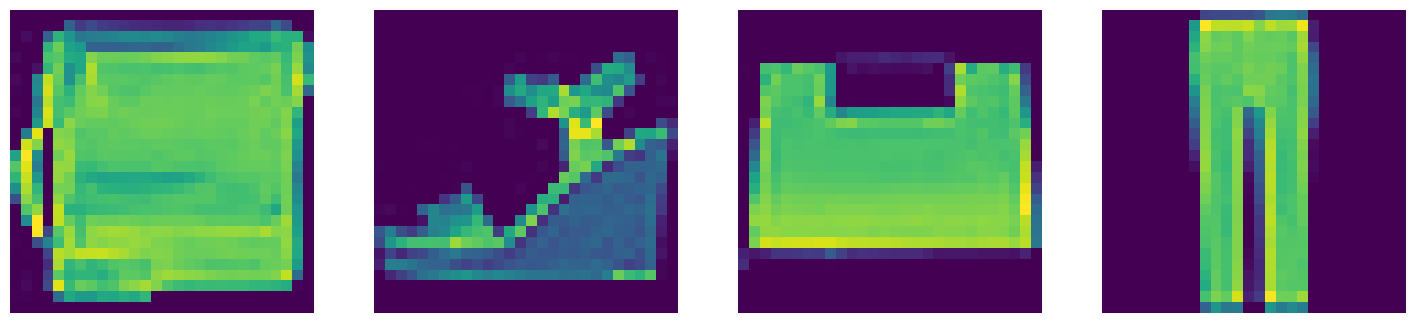

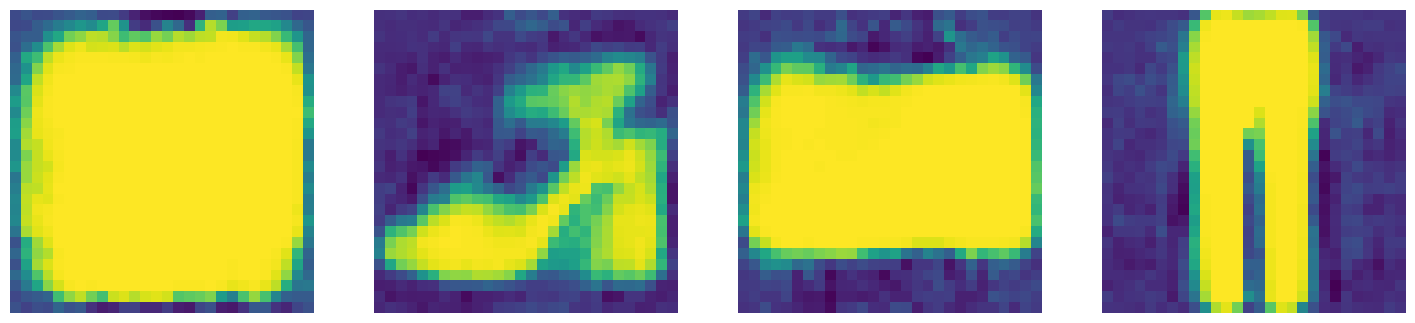

====> Epoch: 2 Average loss: 424.9308
====> Test set loss: 411.8913


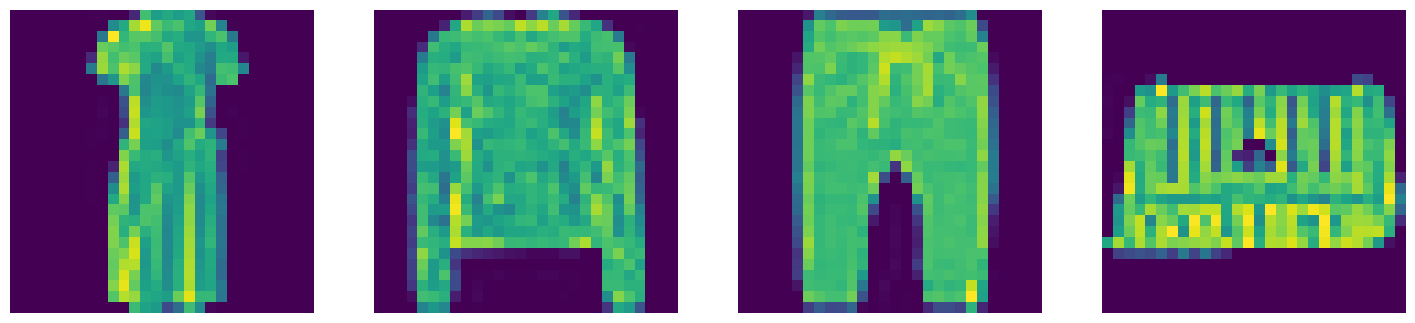

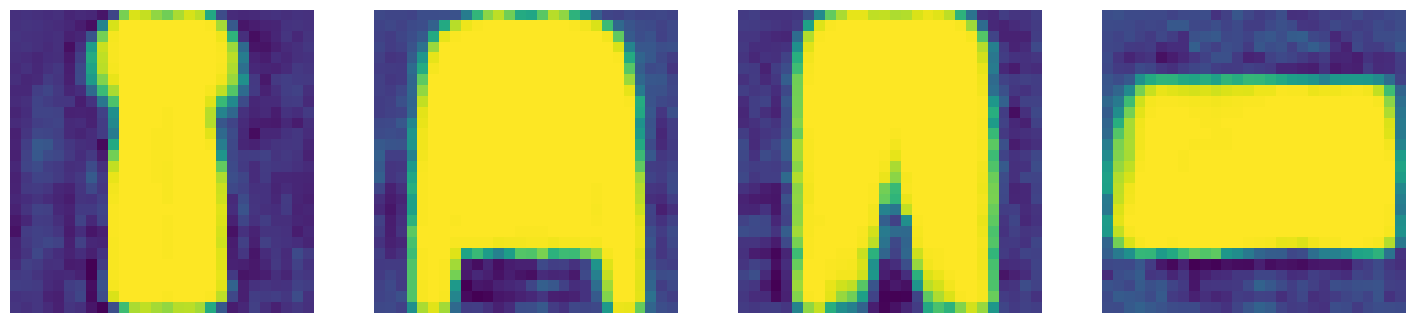

====> Epoch: 3 Average loss: 419.0360
====> Test set loss: 408.1578


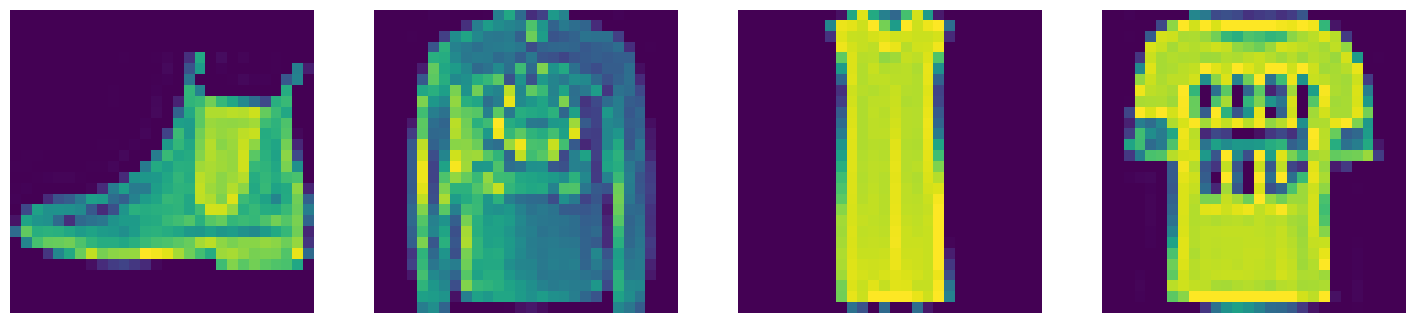

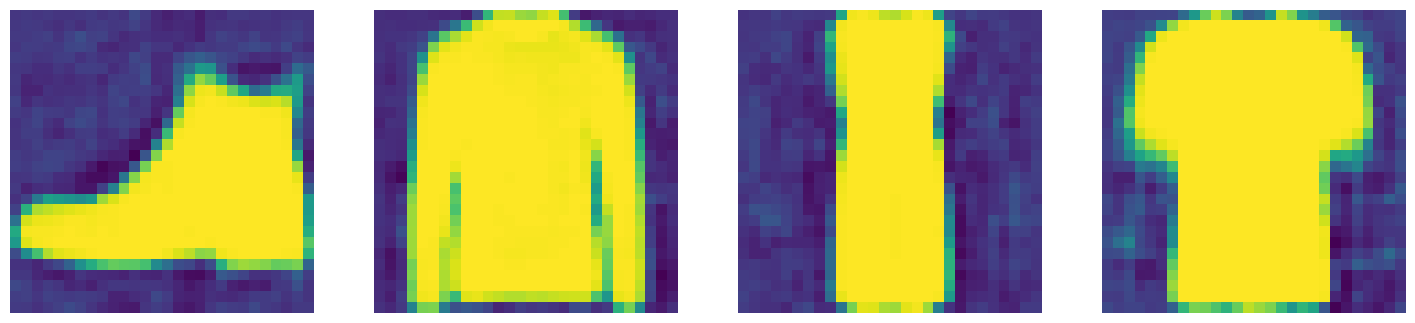

====> Epoch: 4 Average loss: 415.9110
====> Test set loss: 405.6468


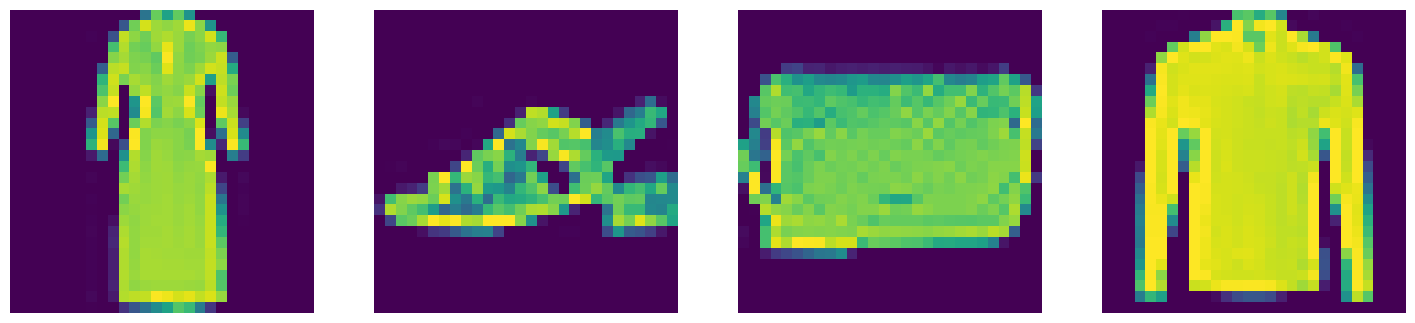

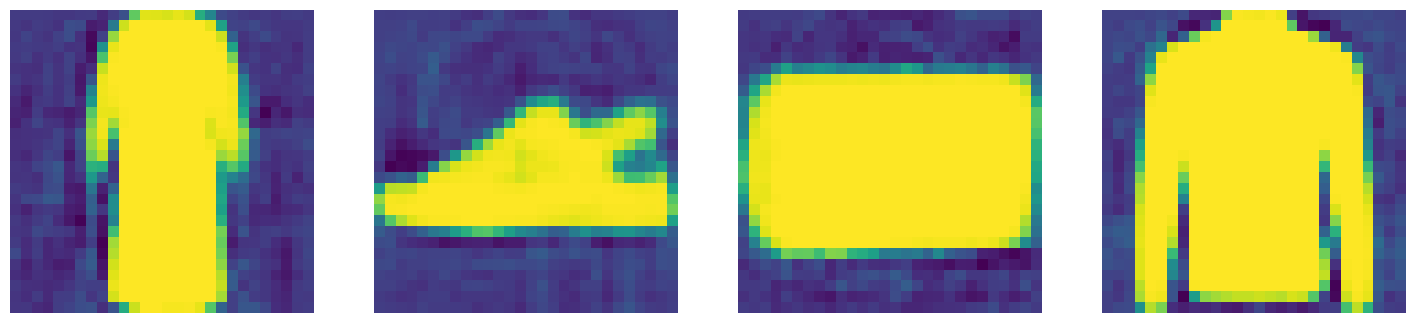

====> Epoch: 5 Average loss: 413.7769
====> Test set loss: 404.4278


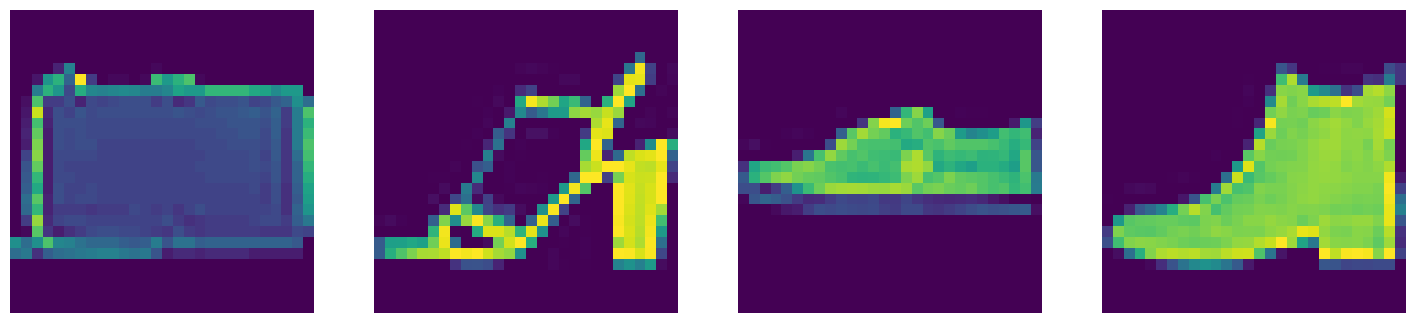

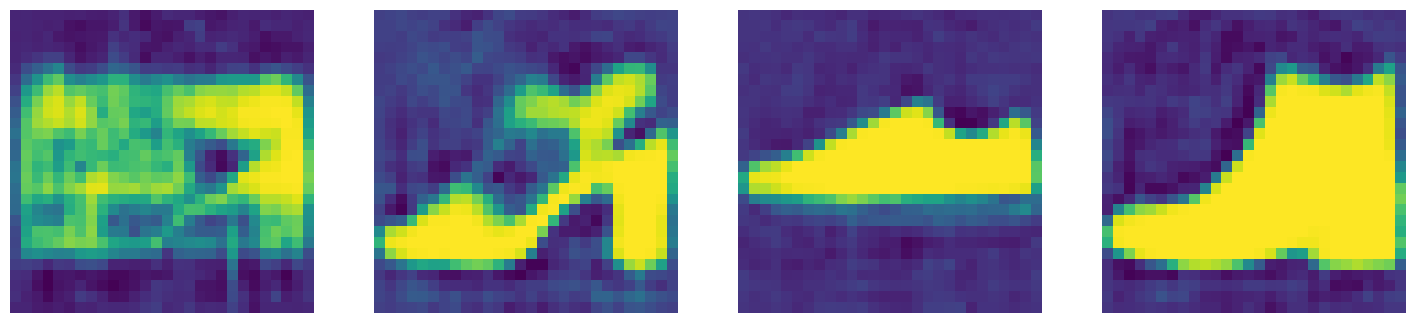

====> Epoch: 6 Average loss: 412.1687
====> Test set loss: 402.7821


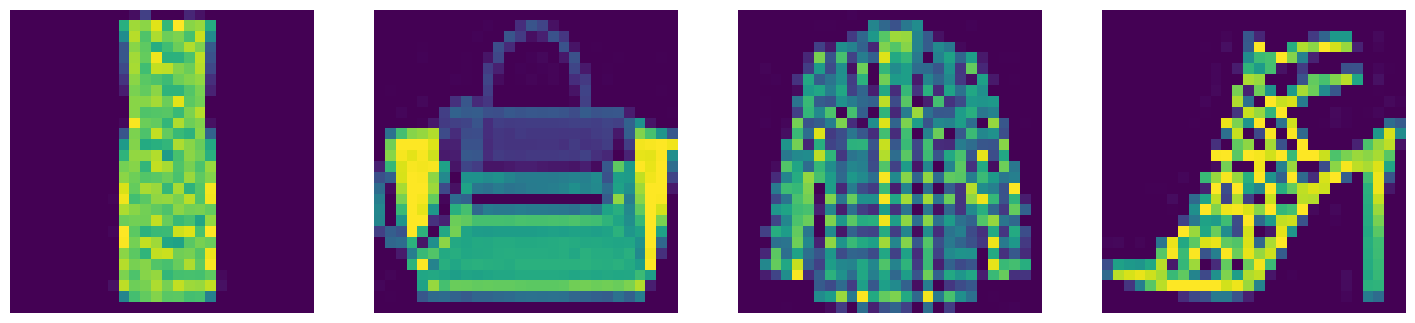

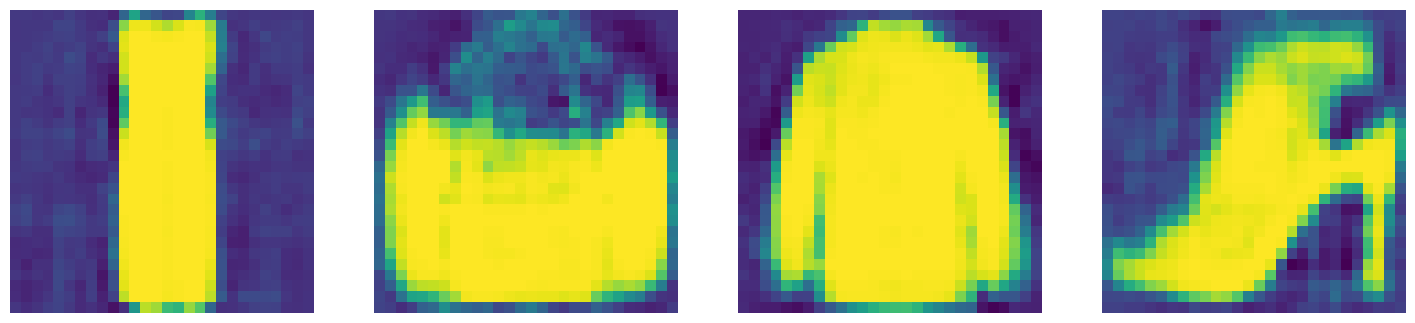

====> Epoch: 7 Average loss: 410.9741
====> Test set loss: 401.9072


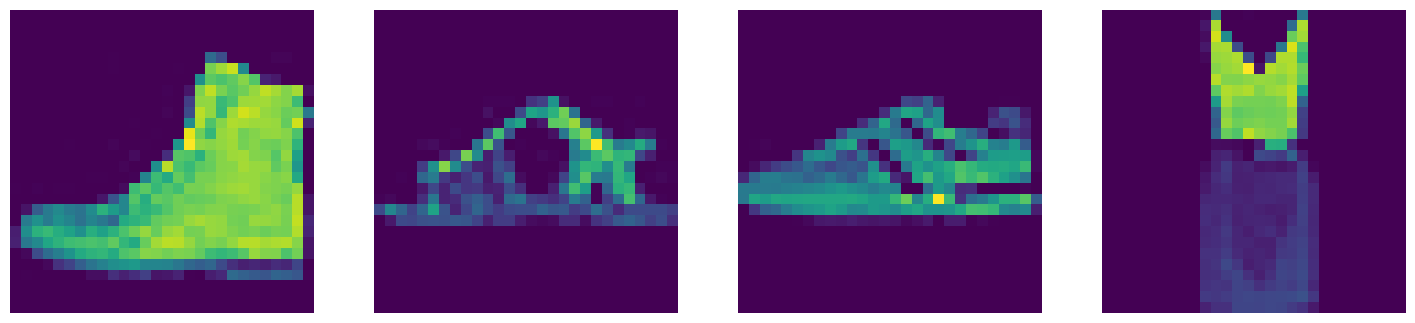

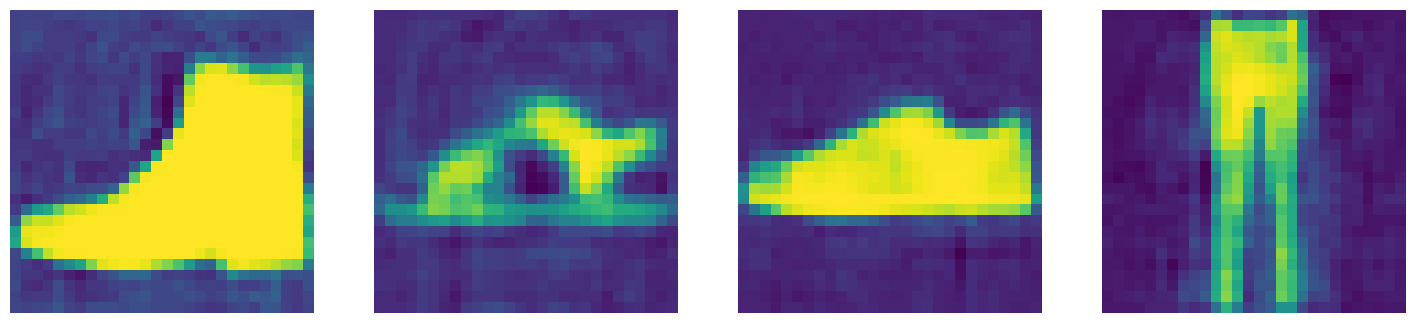

====> Epoch: 8 Average loss: 409.9525
====> Test set loss: 400.9053


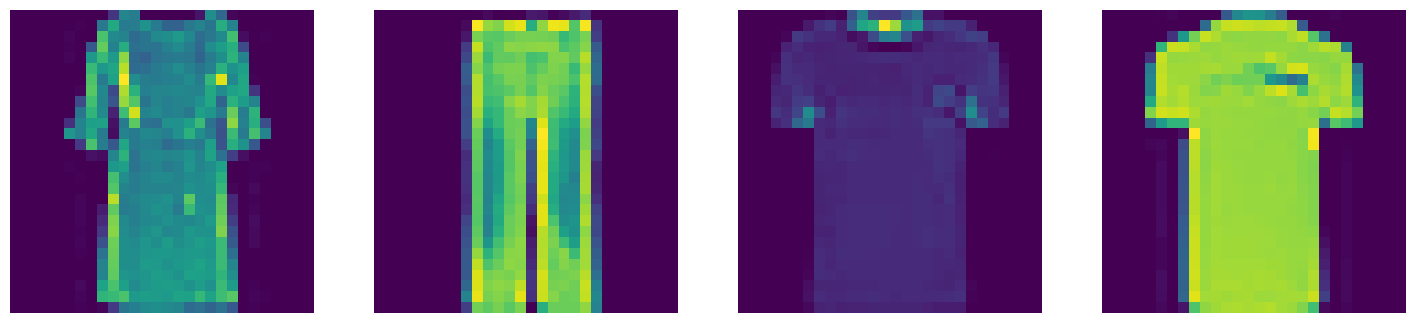

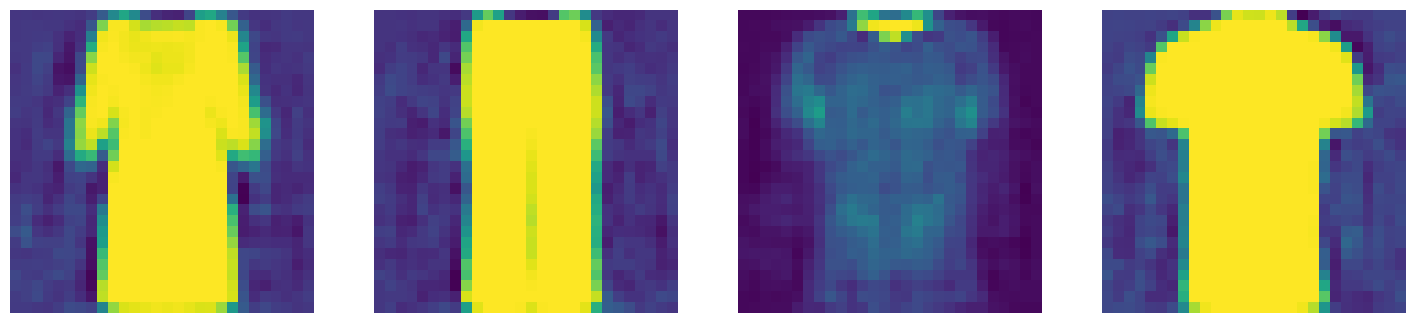

====> Epoch: 9 Average loss: 409.2286
====> Test set loss: 400.9743


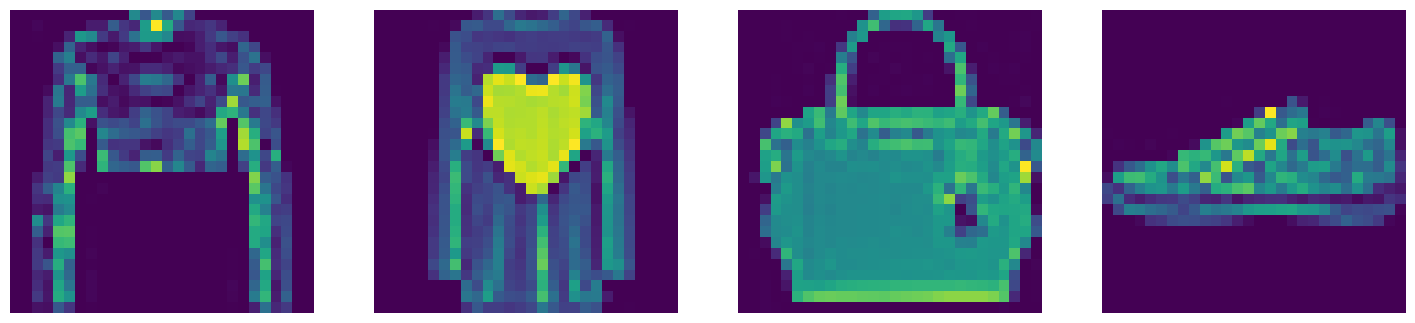

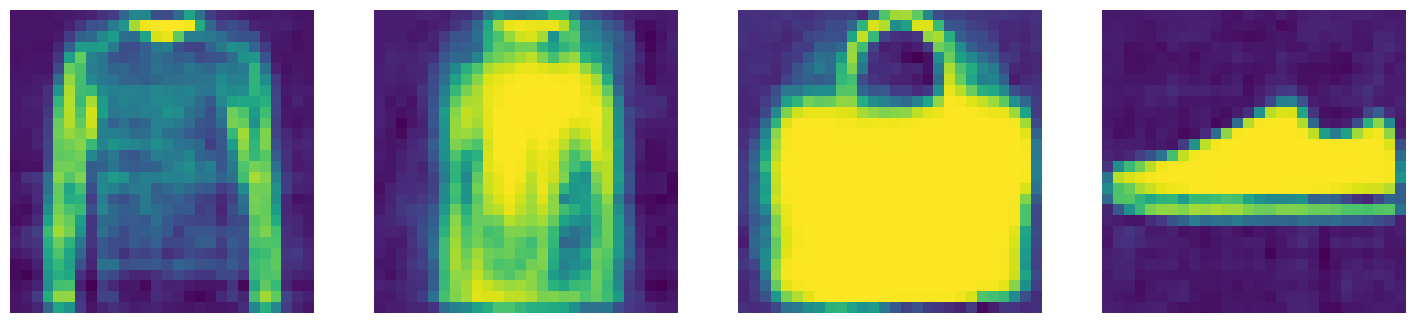

====> Epoch: 10 Average loss: 408.5508
====> Test set loss: 400.4415


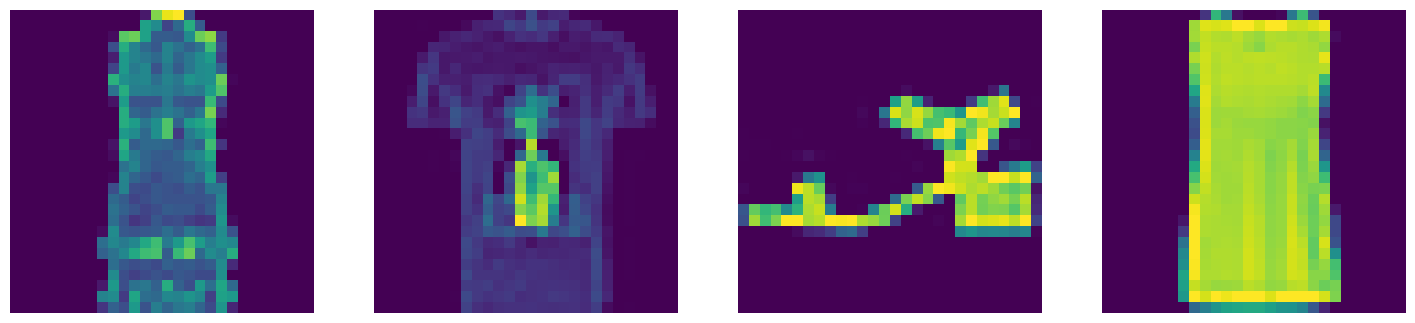

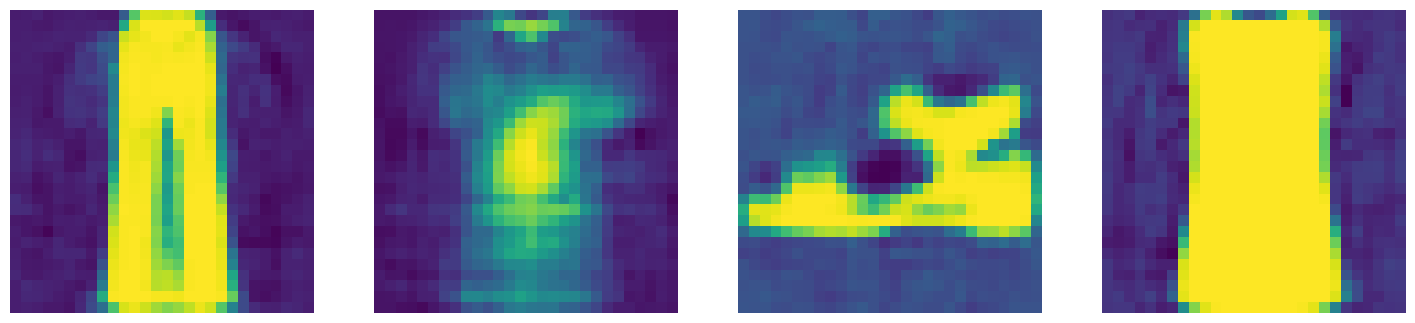

====> Epoch: 11 Average loss: 407.9649
====> Test set loss: 399.0080


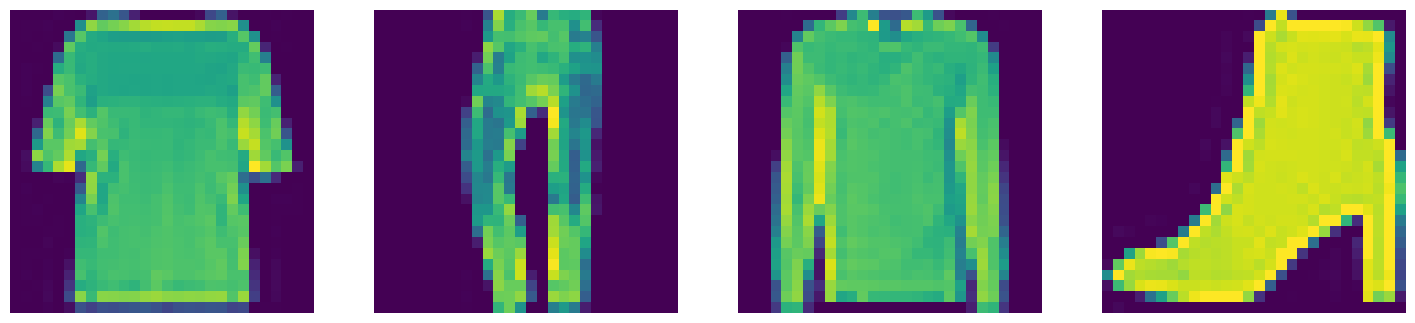

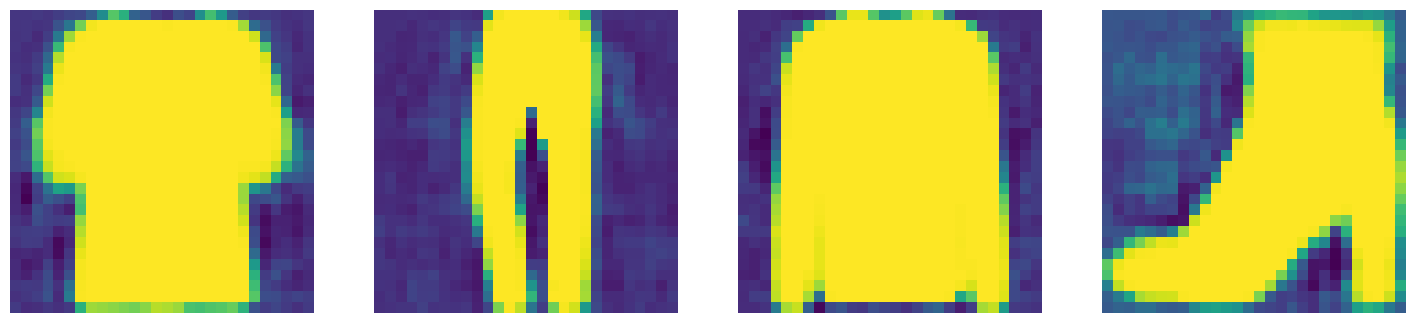

====> Epoch: 12 Average loss: 407.3925
====> Test set loss: 400.2771


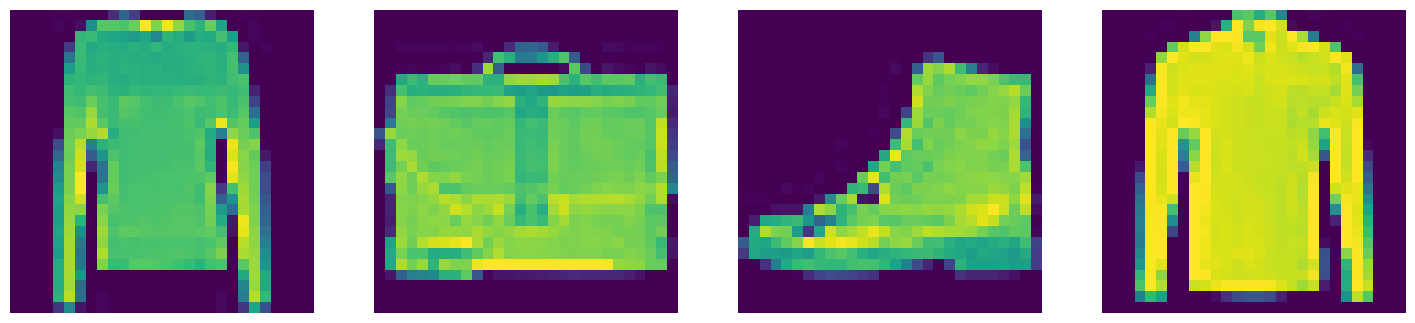

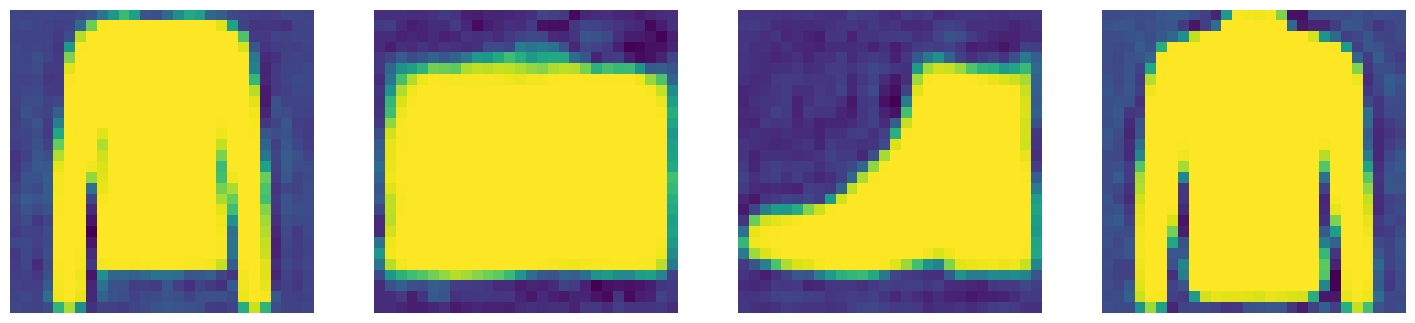

====> Epoch: 13 Average loss: 406.9659
====> Test set loss: 397.1113


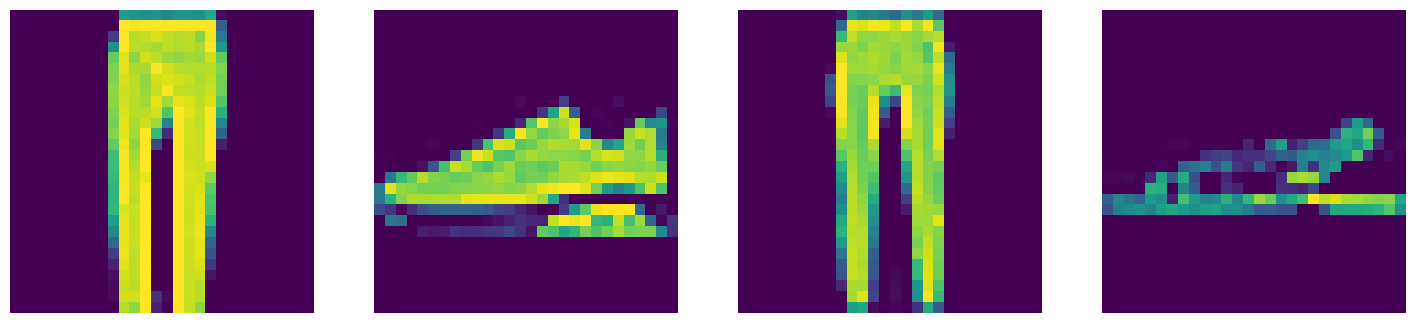

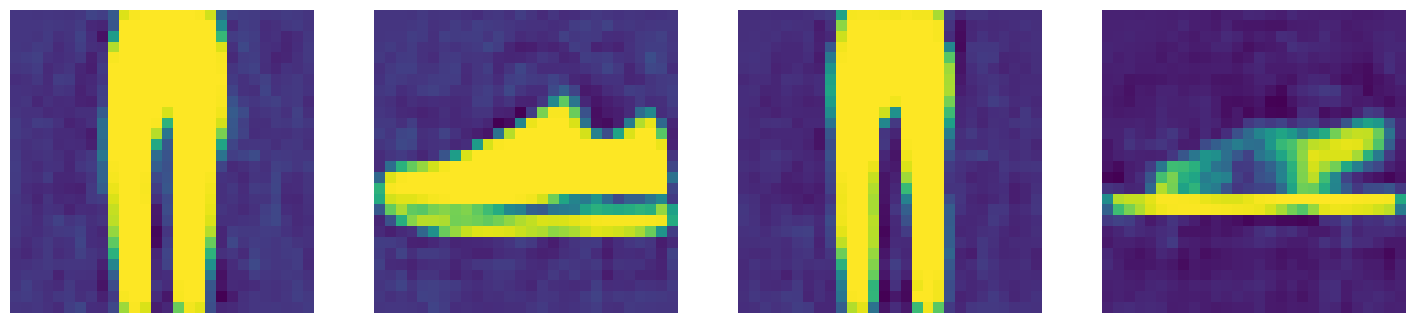

====> Epoch: 14 Average loss: 406.5902
====> Test set loss: 397.8230


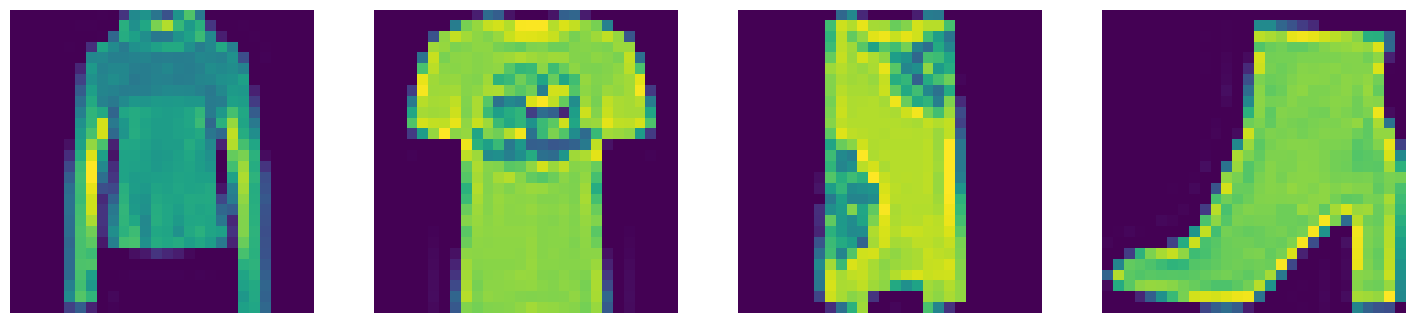

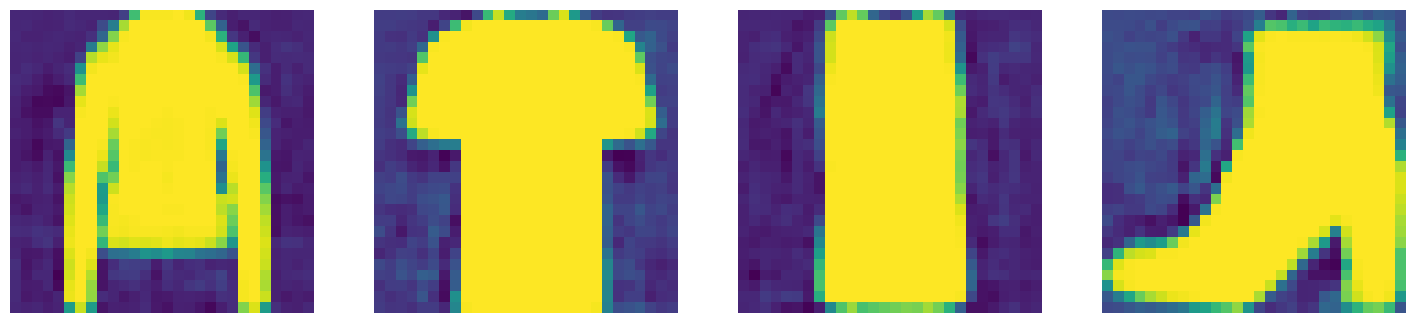

====> Epoch: 15 Average loss: 406.2516
====> Test set loss: 398.1462


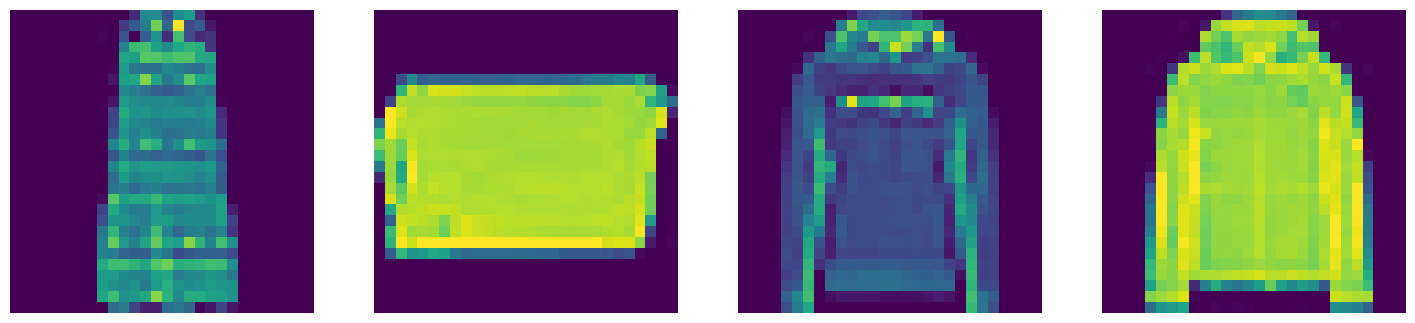

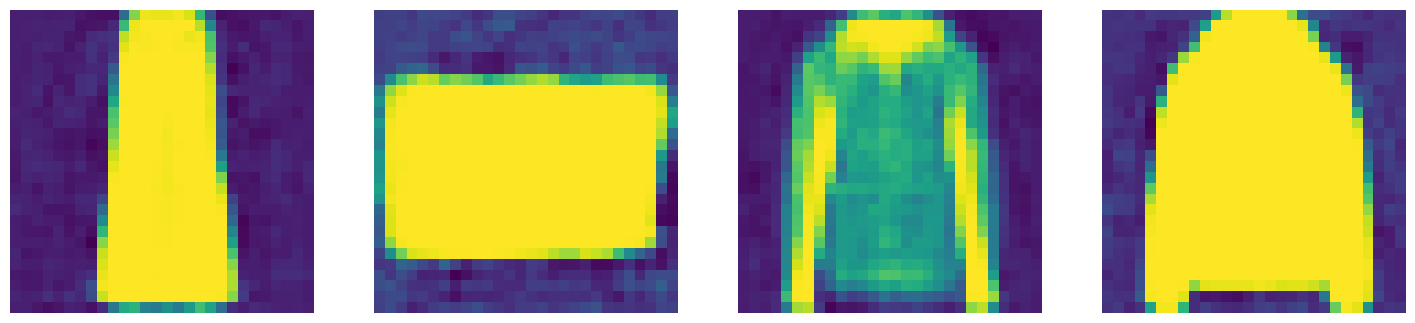

====> Epoch: 16 Average loss: 405.9065
====> Test set loss: 397.7465


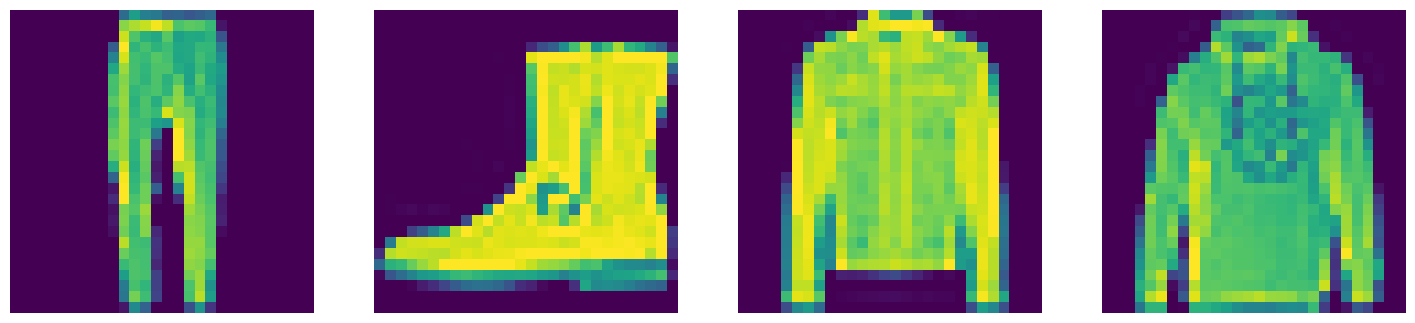

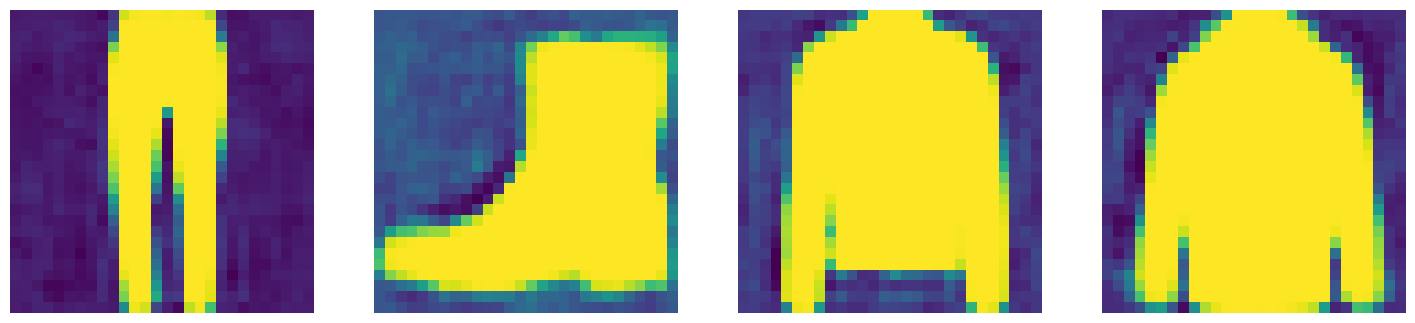

====> Epoch: 17 Average loss: 405.6222
====> Test set loss: 397.7176


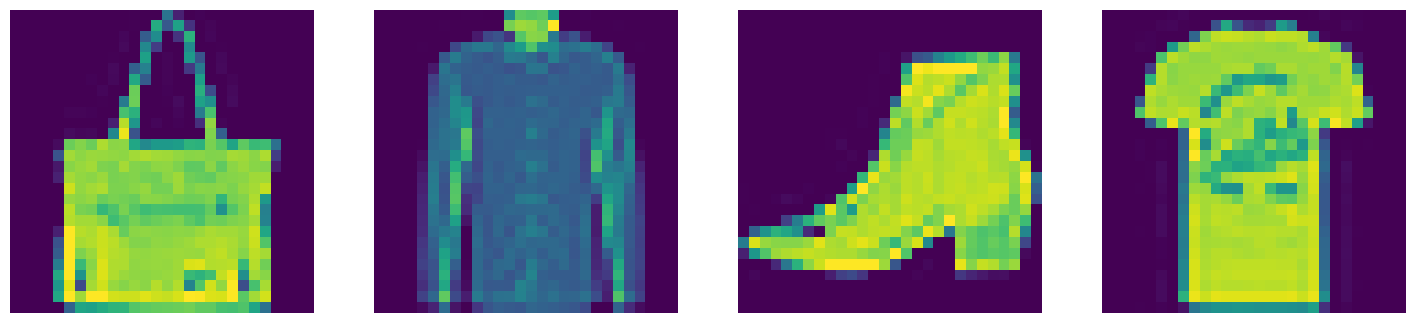

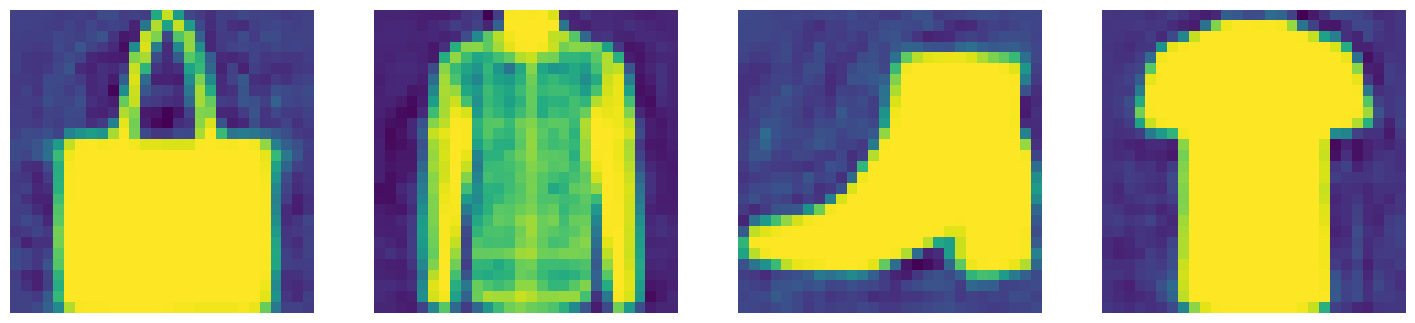

====> Epoch: 18 Average loss: 405.3510
====> Test set loss: 397.4322


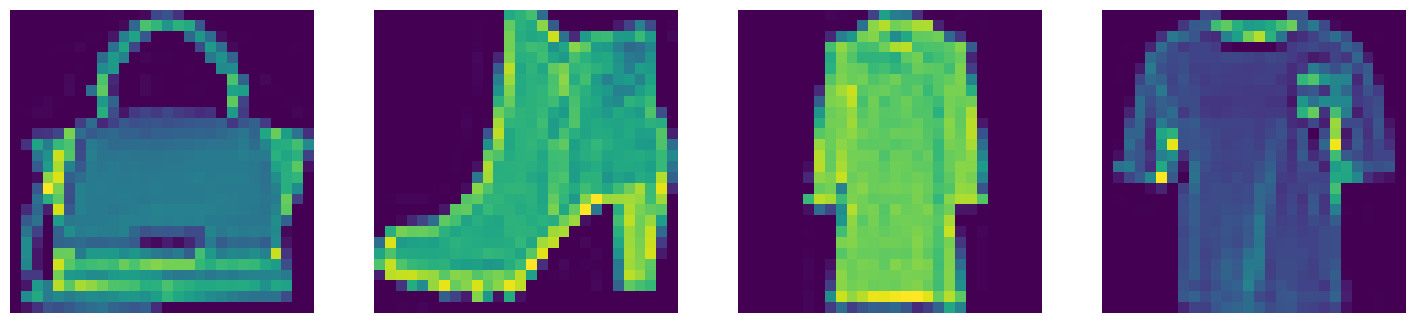

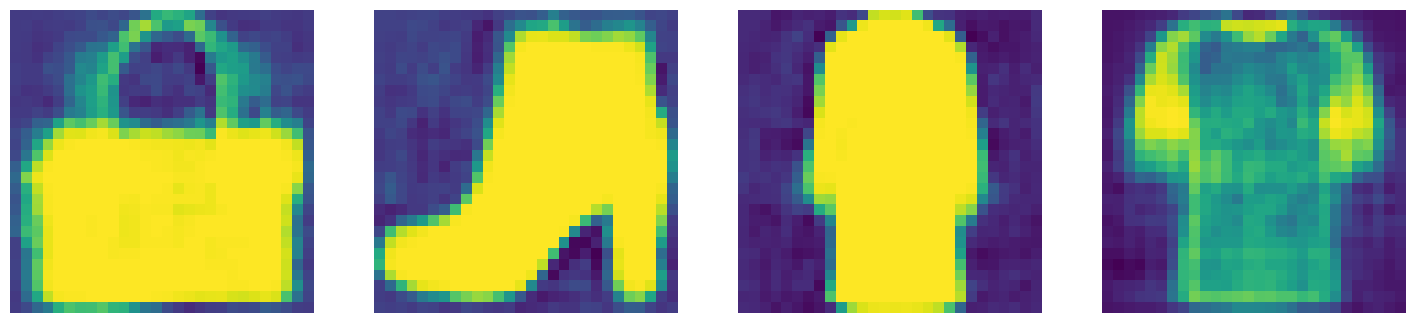

====> Epoch: 19 Average loss: 405.1408
====> Test set loss: 396.4892


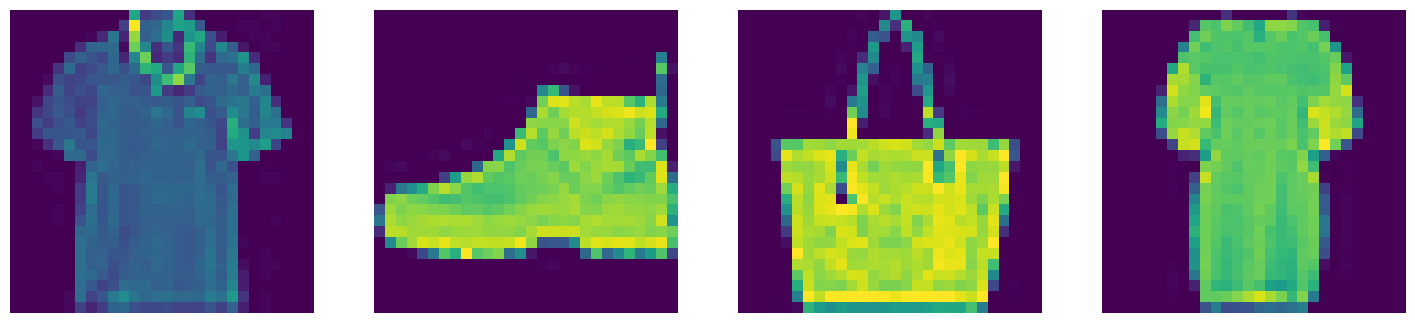

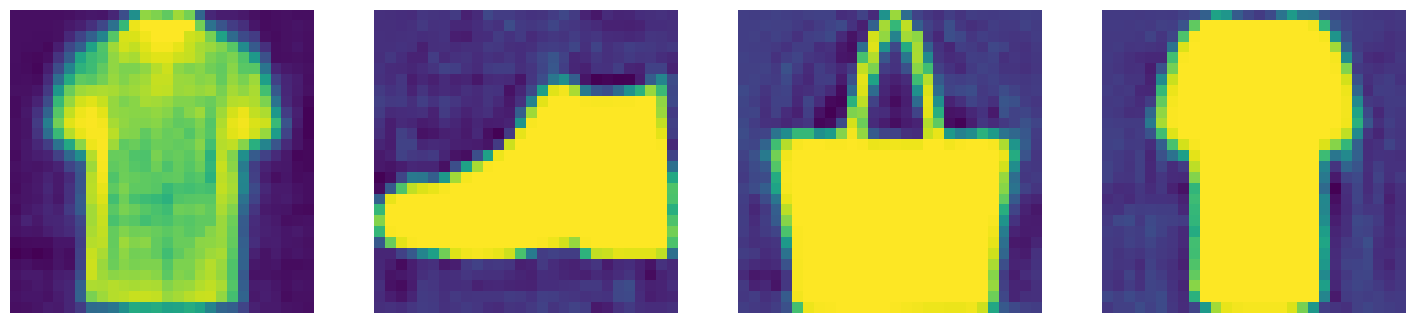

====> Epoch: 20 Average loss: 404.8707
====> Test set loss: 396.4882


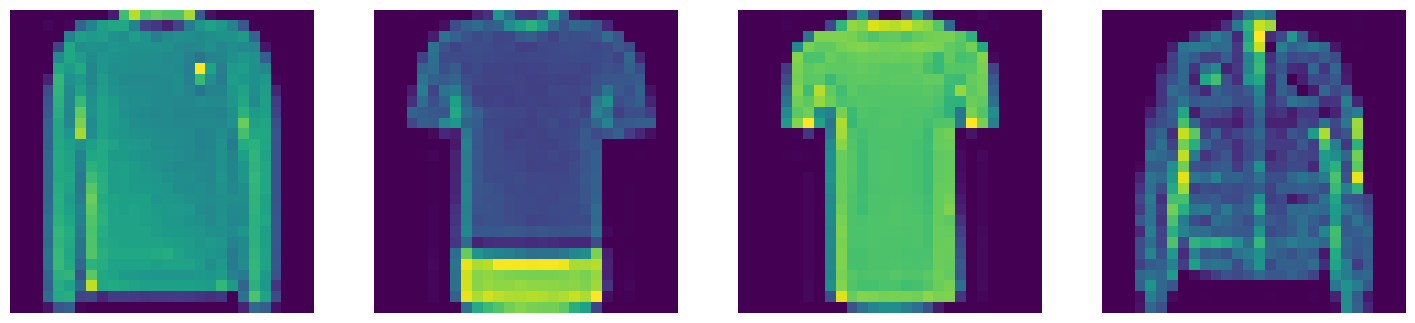

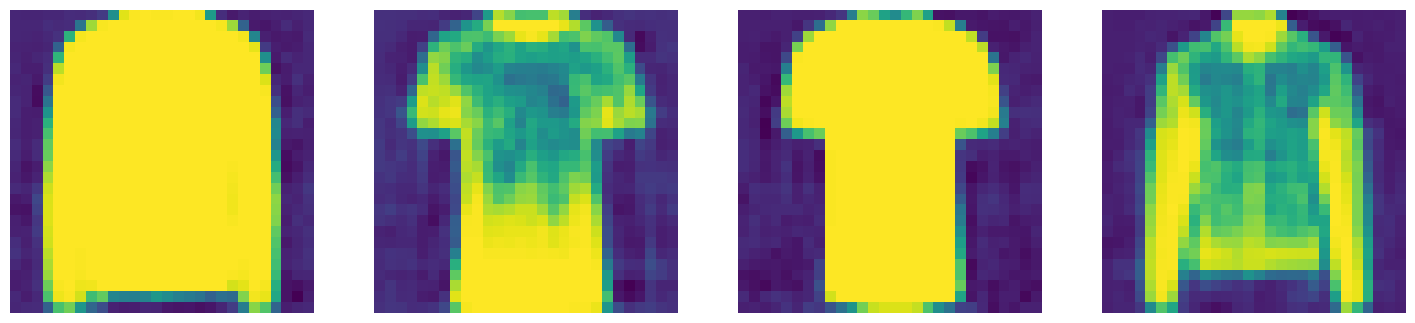

====> Epoch: 21 Average loss: 404.5868
====> Test set loss: 396.2829


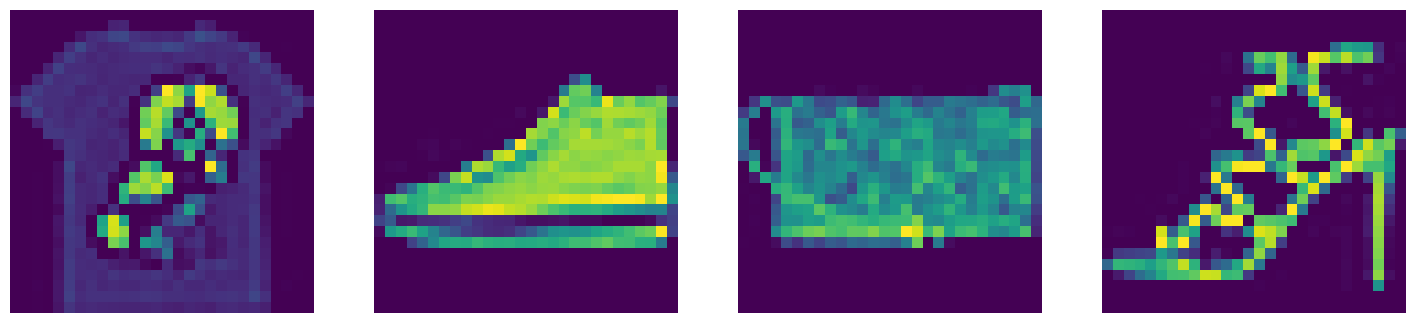

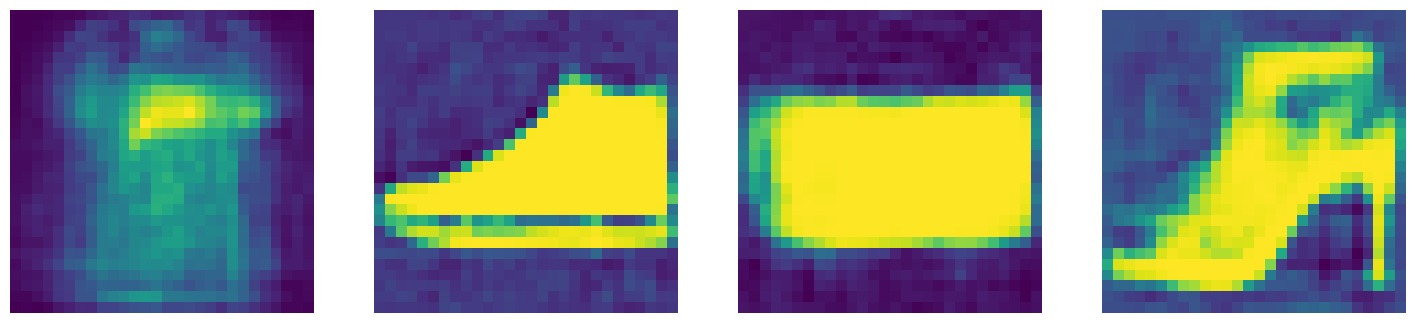

====> Epoch: 22 Average loss: 404.4859
====> Test set loss: 397.0347


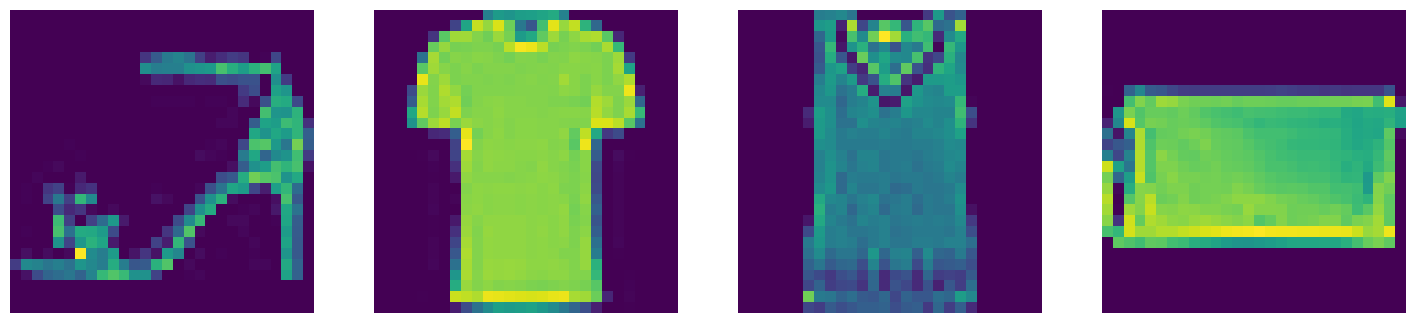

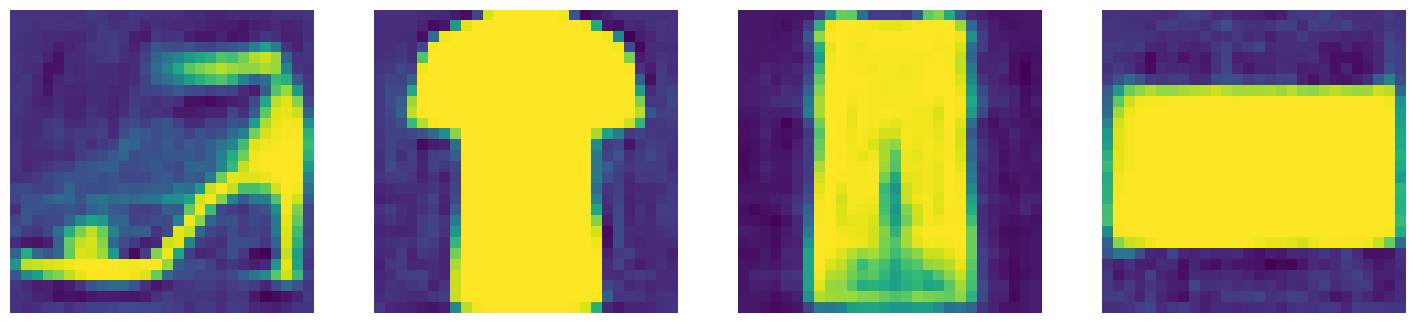

====> Epoch: 23 Average loss: 404.2198
====> Test set loss: 396.3190


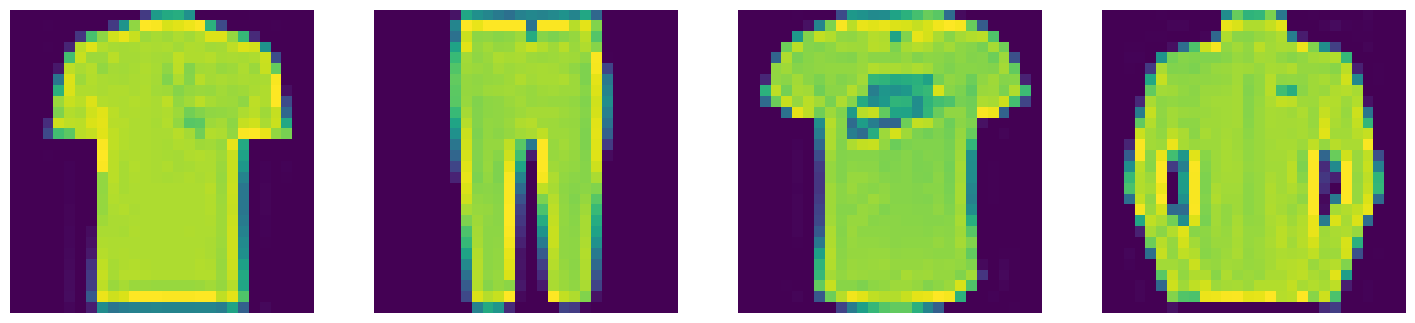

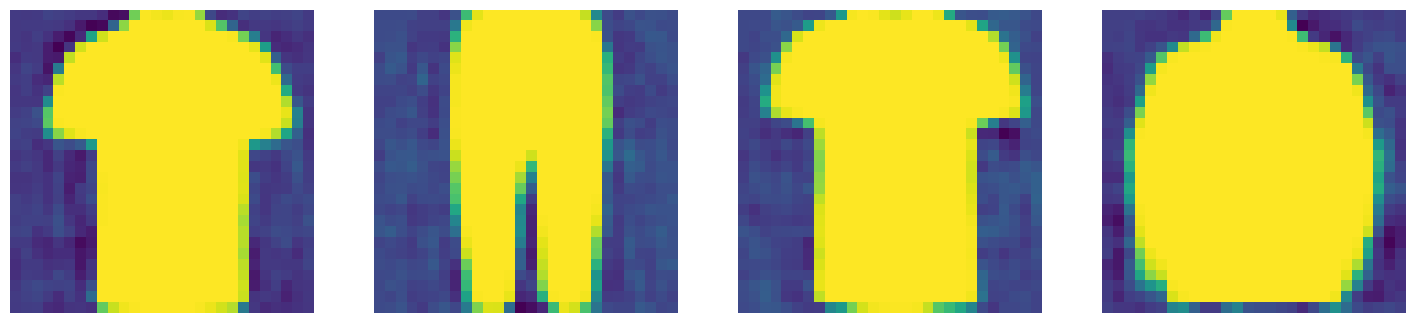

====> Epoch: 24 Average loss: 404.1373
====> Test set loss: 396.5792


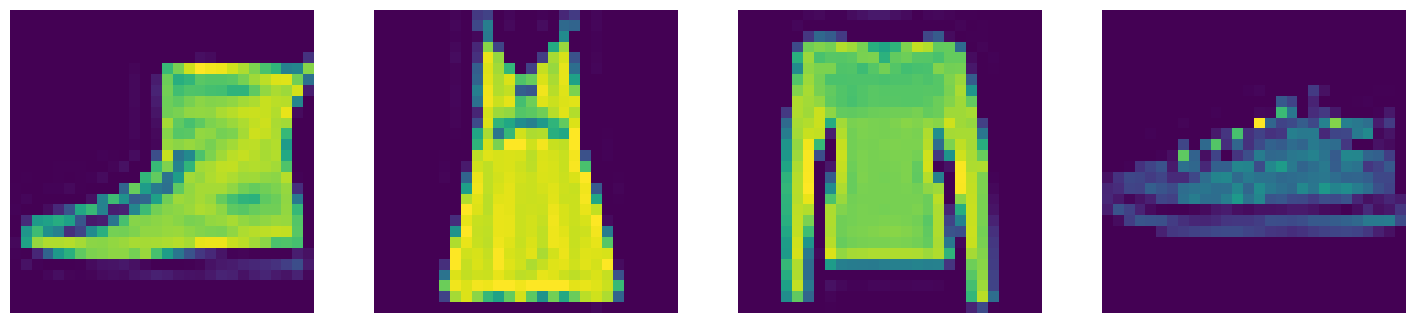

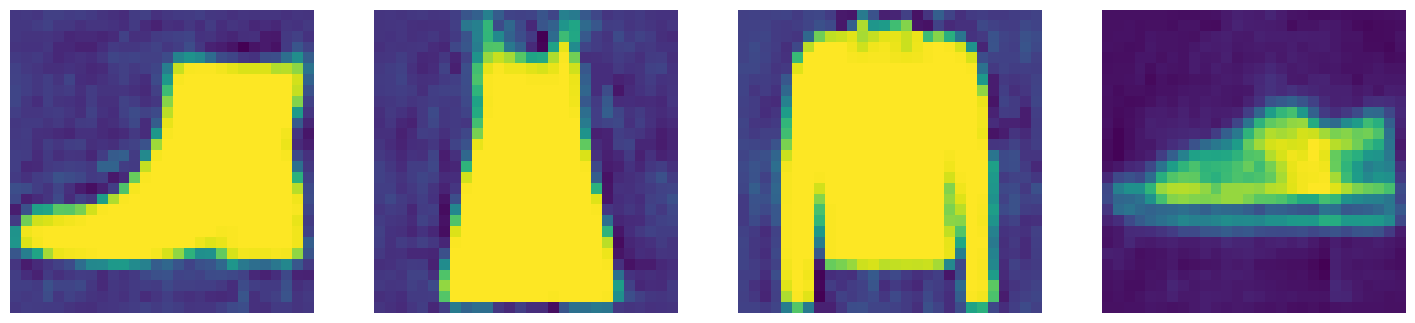

====> Epoch: 25 Average loss: 404.0225
====> Test set loss: 396.0262


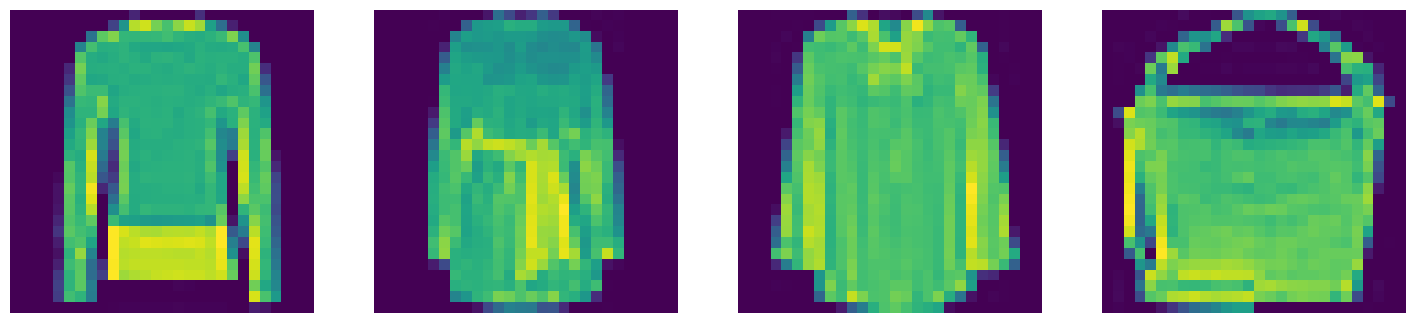

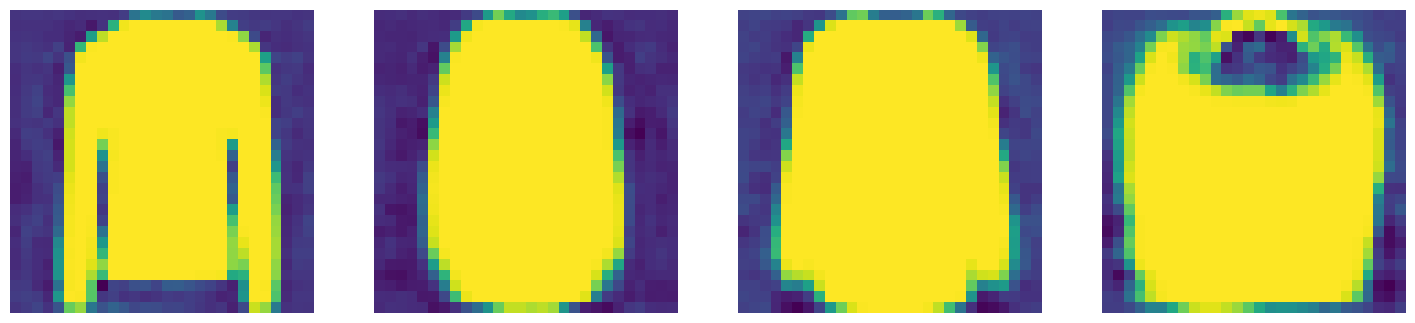

====> Epoch: 26 Average loss: 403.8596
====> Test set loss: 395.6069


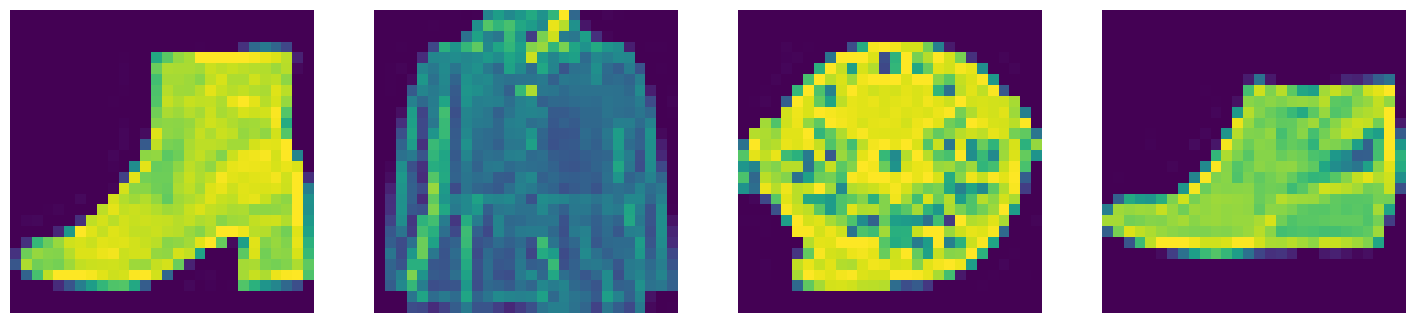

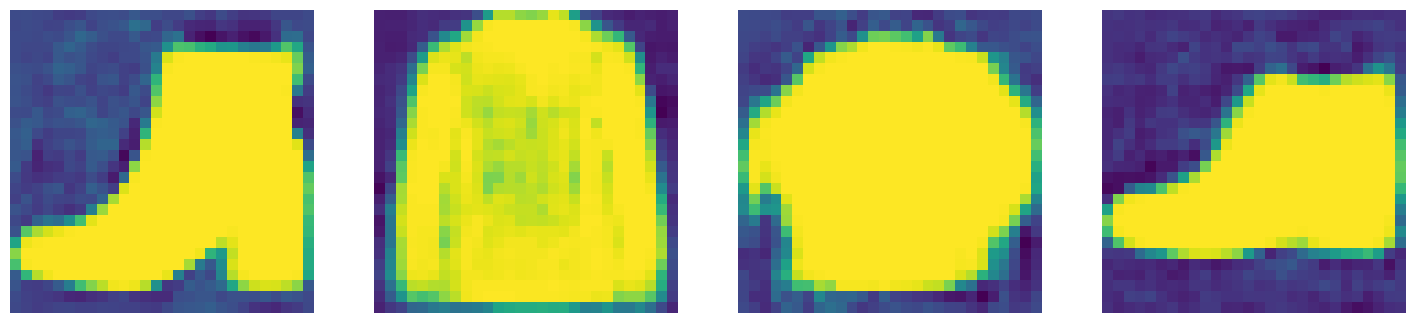

====> Epoch: 27 Average loss: 403.7778
====> Test set loss: 395.3167


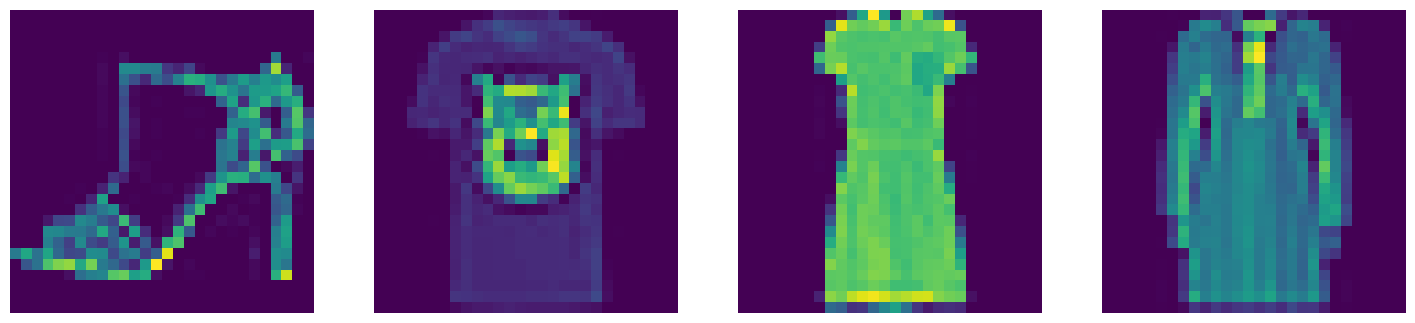

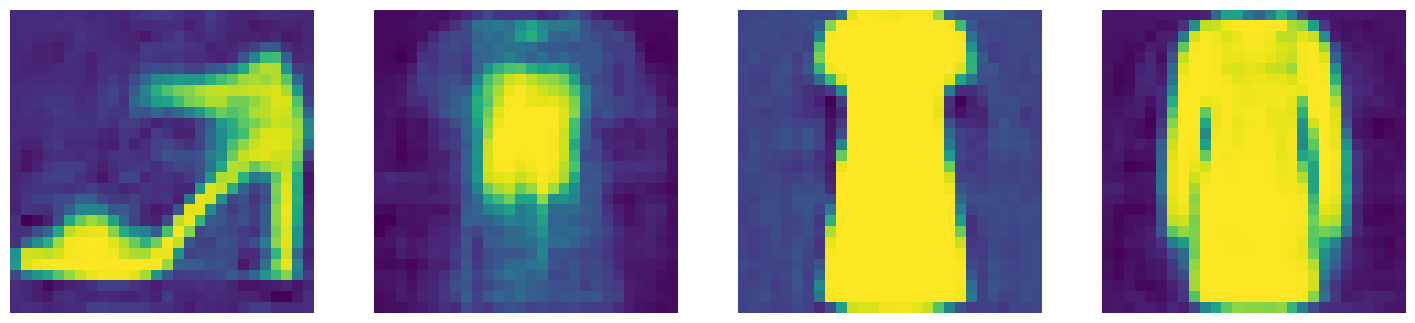

====> Epoch: 28 Average loss: 403.5924
====> Test set loss: 395.8320


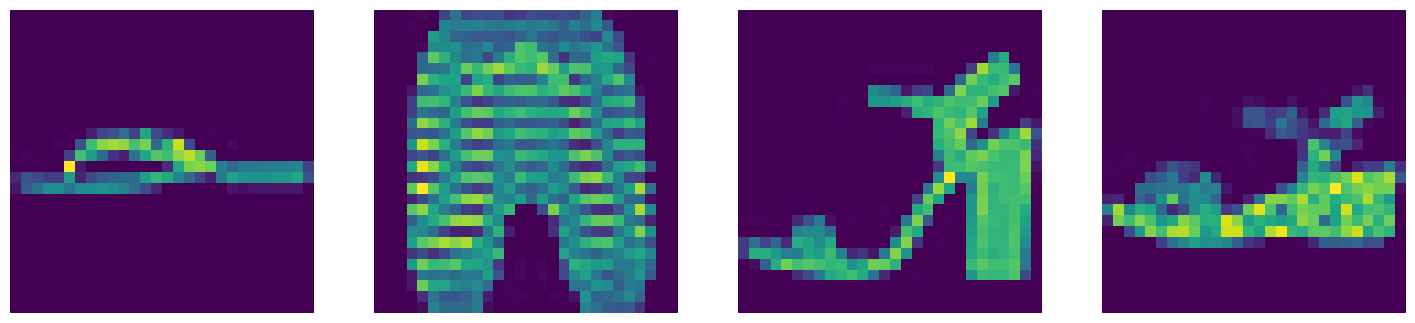

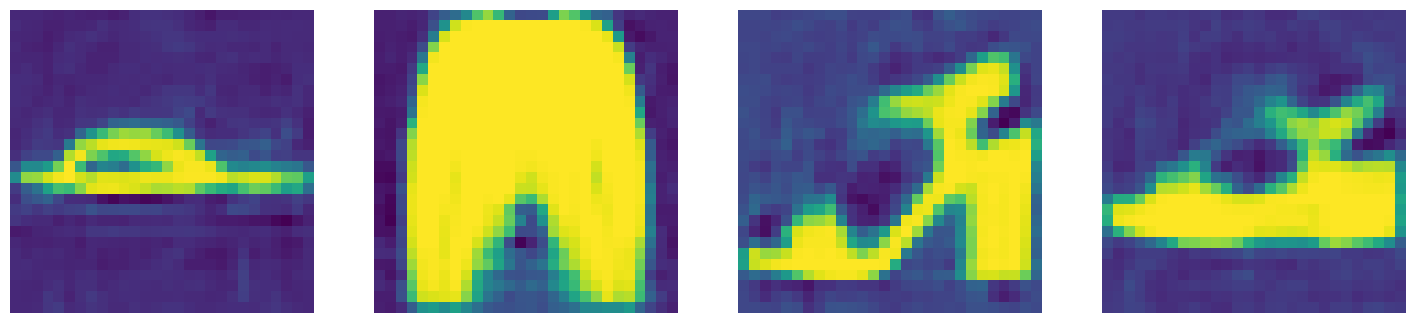

====> Epoch: 29 Average loss: 403.4609
====> Test set loss: 397.4744


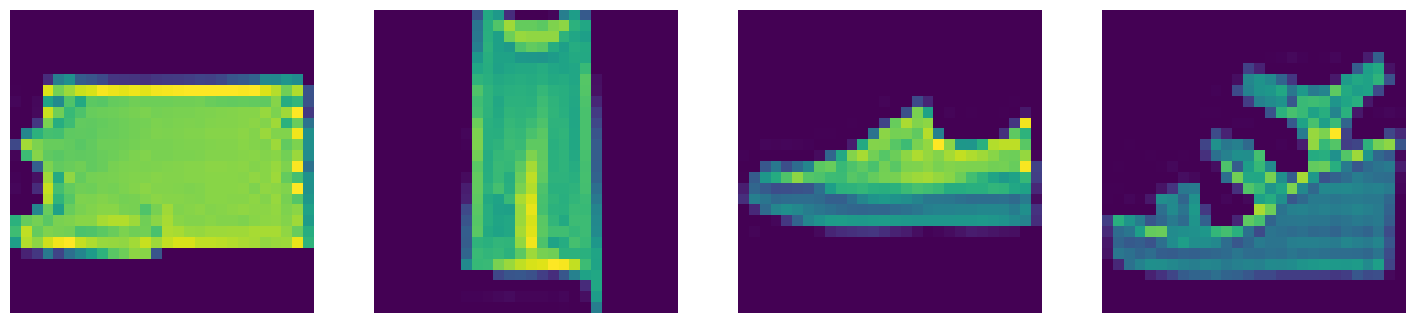

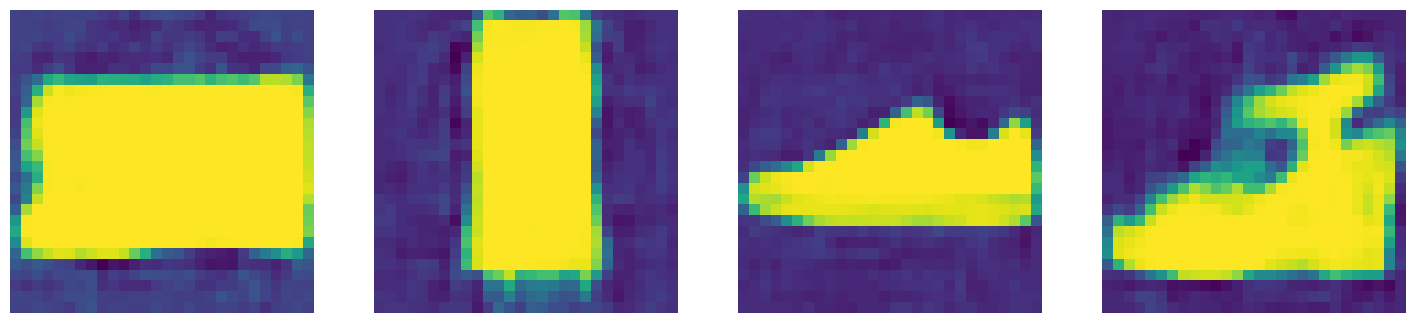

====> Epoch: 30 Average loss: 403.4142
====> Test set loss: 395.6952


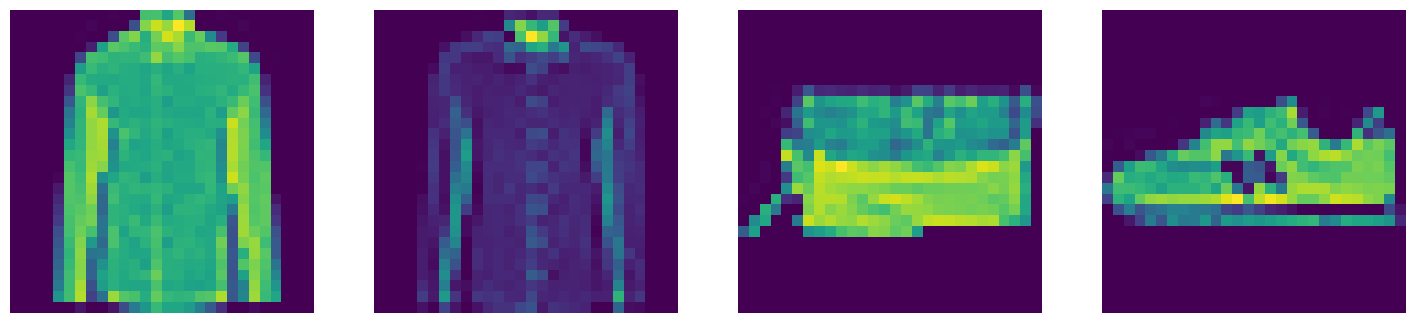

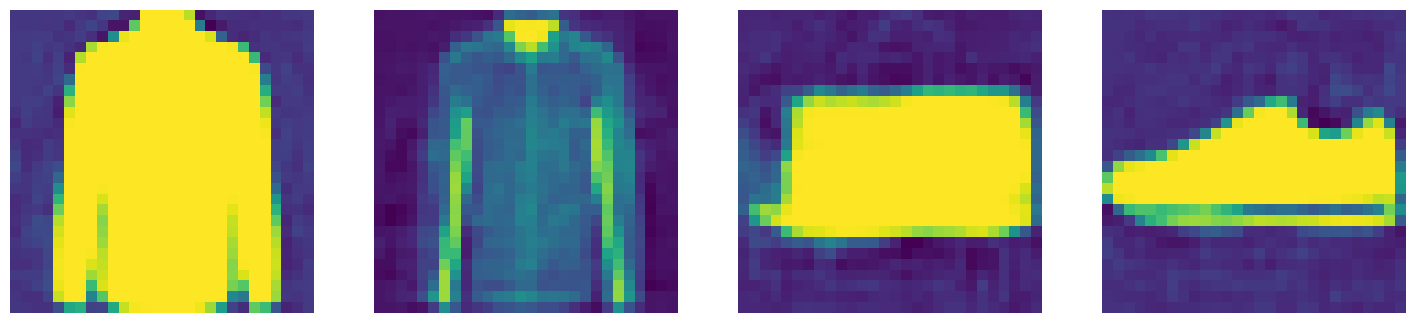

====> Epoch: 31 Average loss: 403.2489
====> Test set loss: 395.4647


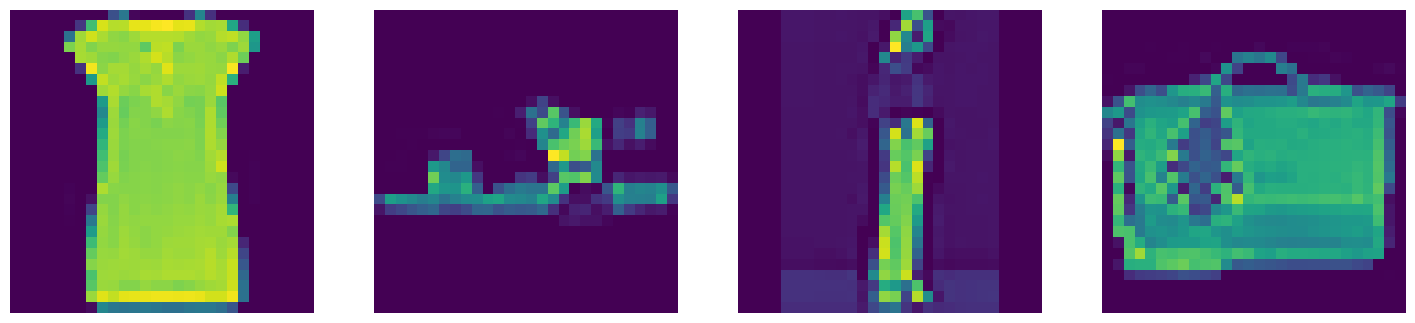

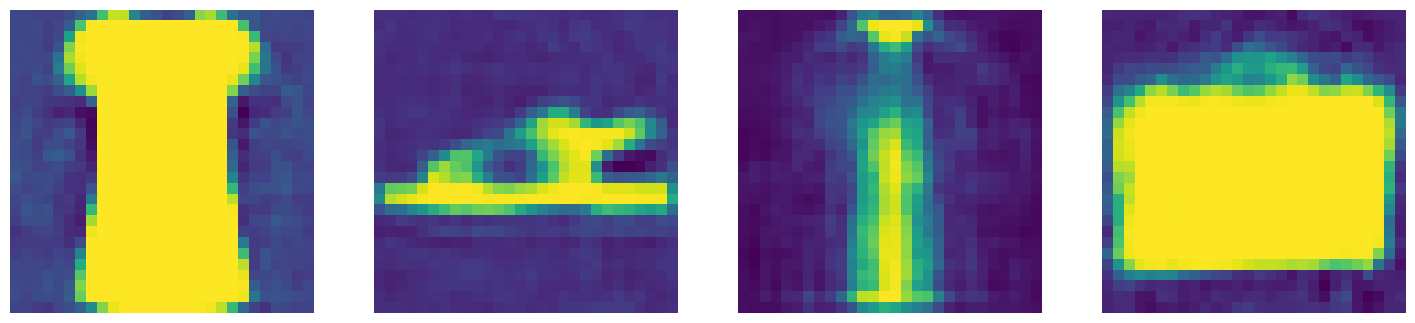

====> Epoch: 32 Average loss: 403.1149
====> Test set loss: 395.2564


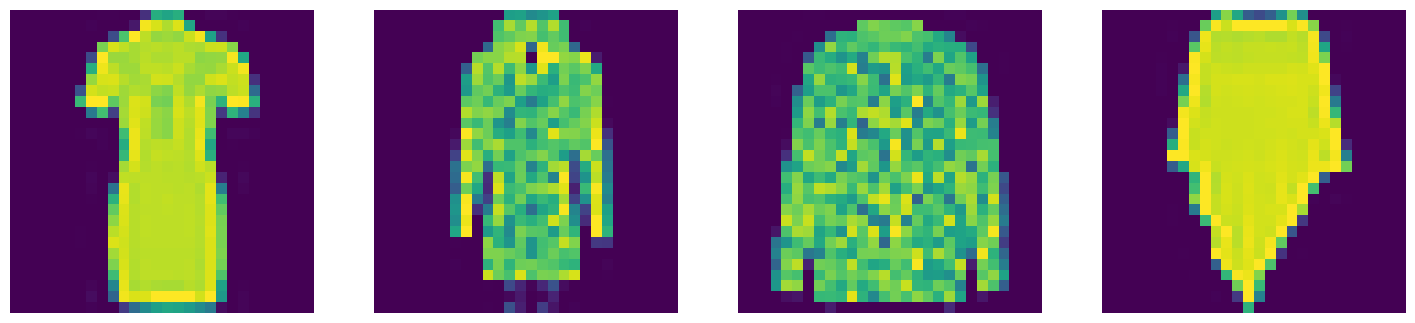

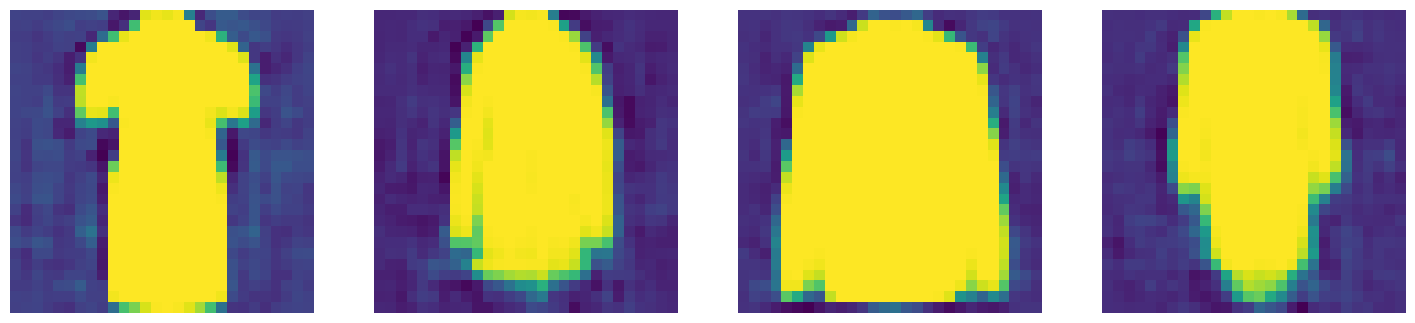

====> Epoch: 33 Average loss: 403.1079
====> Test set loss: 395.7853


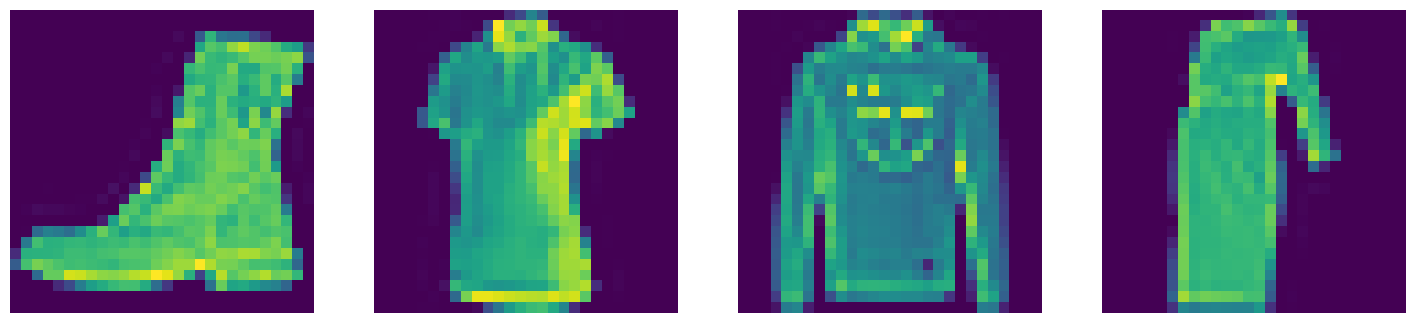

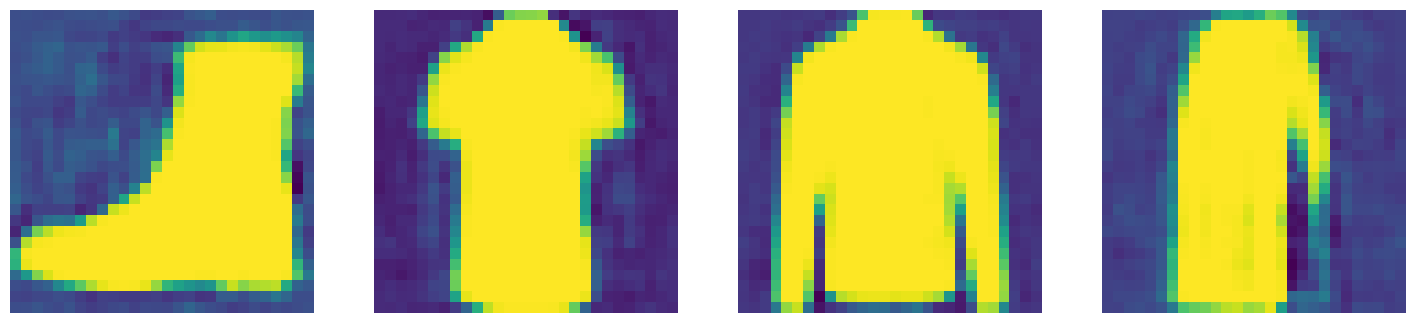

====> Epoch: 34 Average loss: 402.9686
====> Test set loss: 395.5838


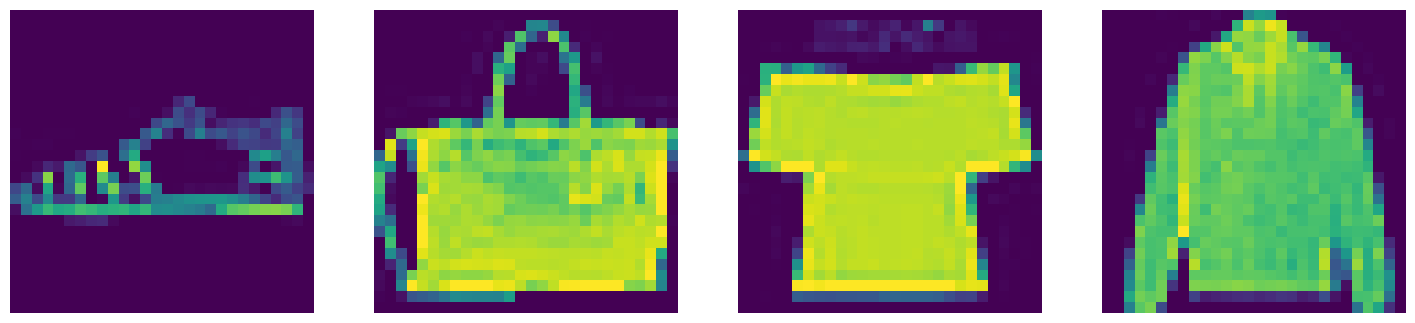

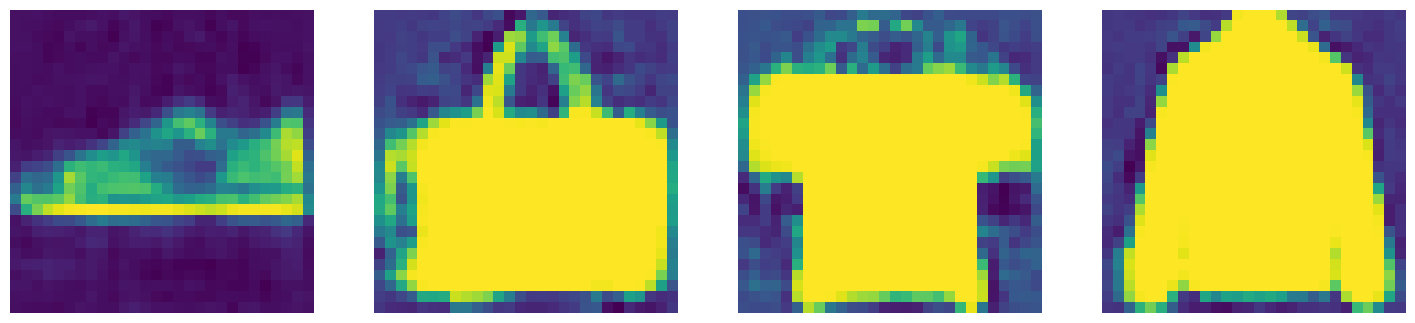

====> Epoch: 35 Average loss: 402.9277
====> Test set loss: 396.3238


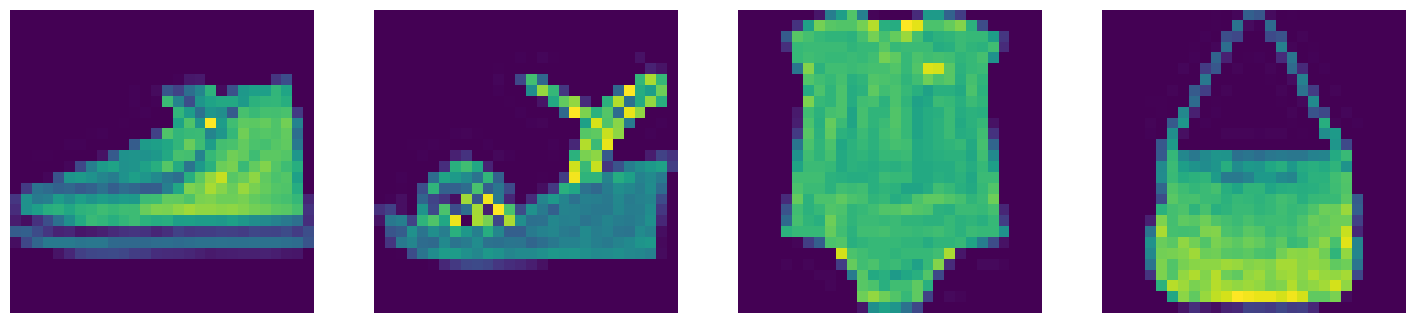

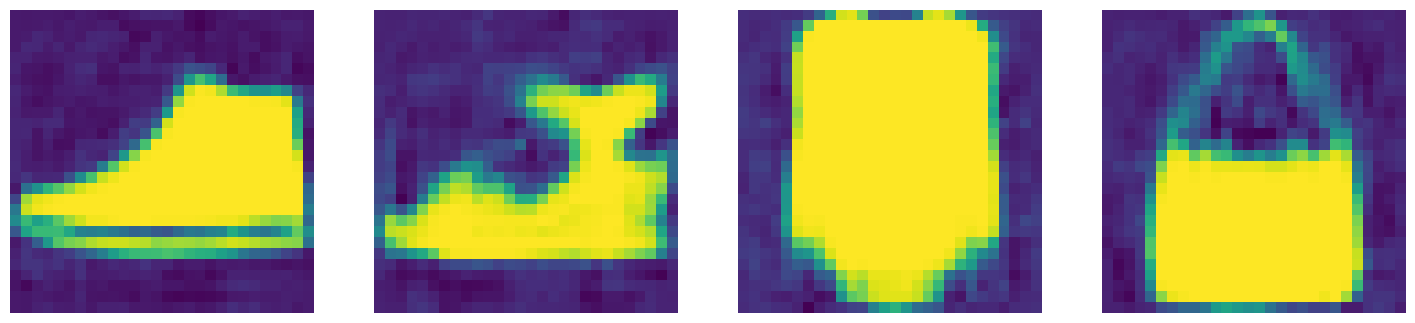

====> Epoch: 36 Average loss: 402.8414
====> Test set loss: 395.7613


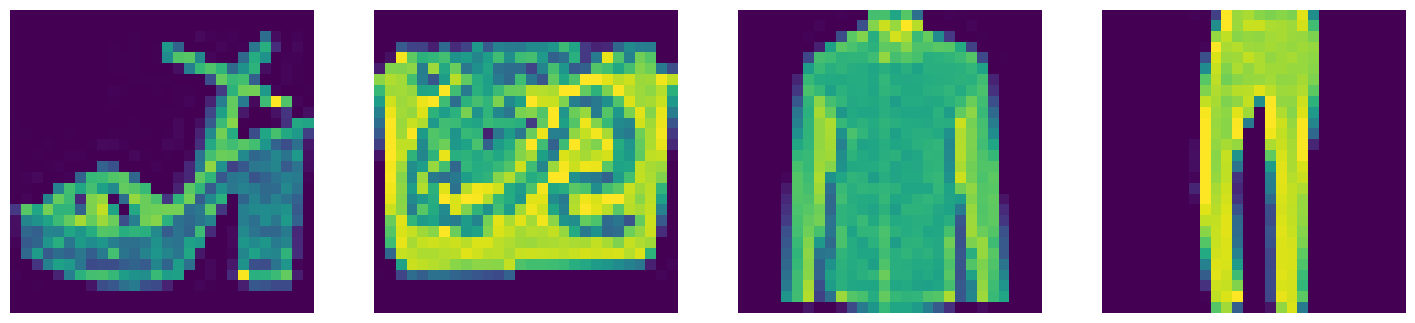

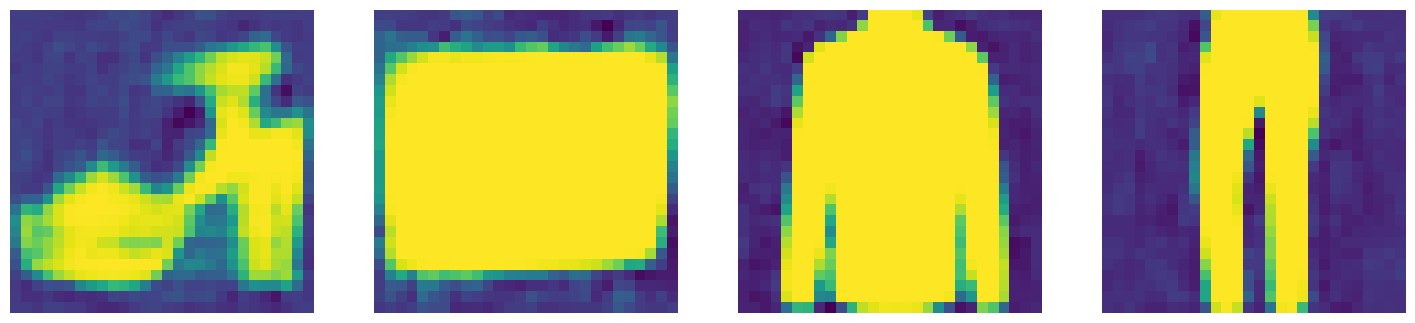

====> Epoch: 37 Average loss: 402.7942
====> Test set loss: 395.7281


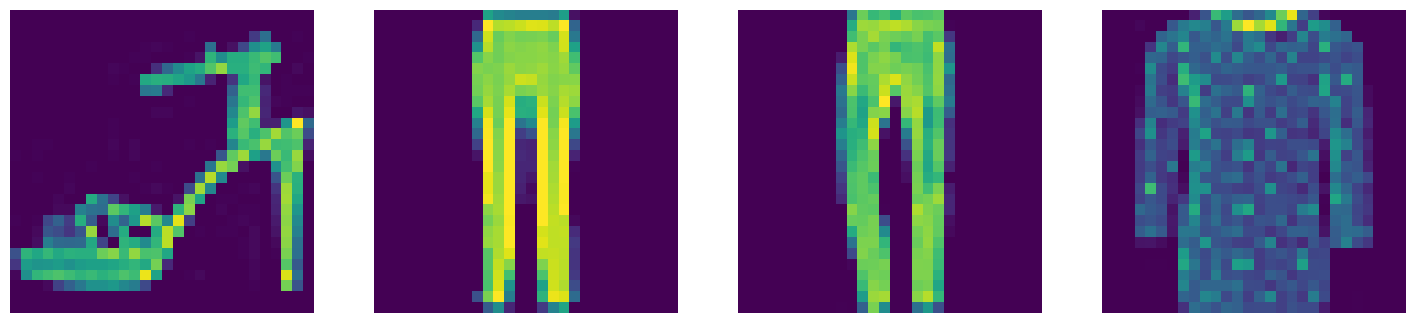

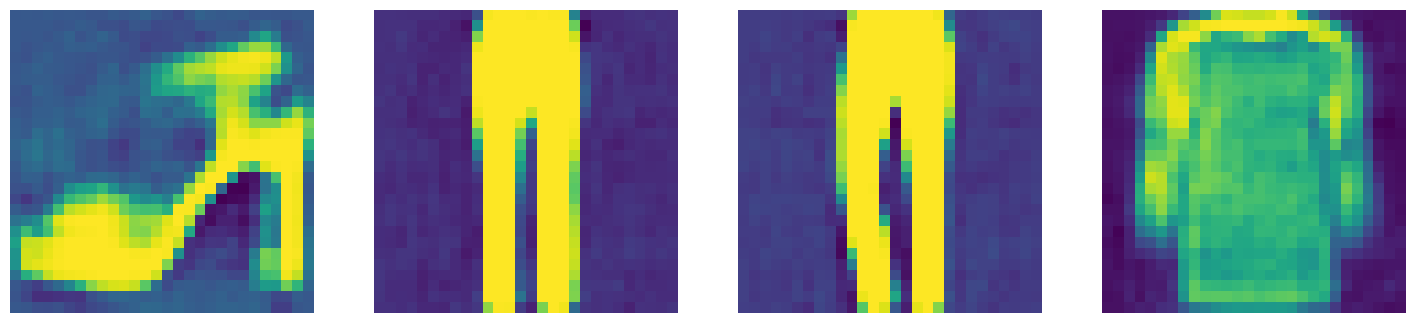

====> Epoch: 38 Average loss: 402.6671
====> Test set loss: 395.7600


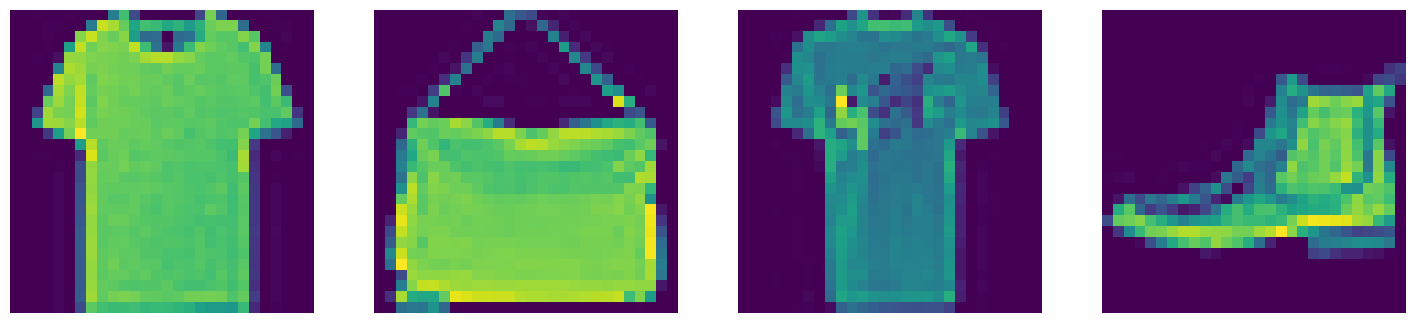

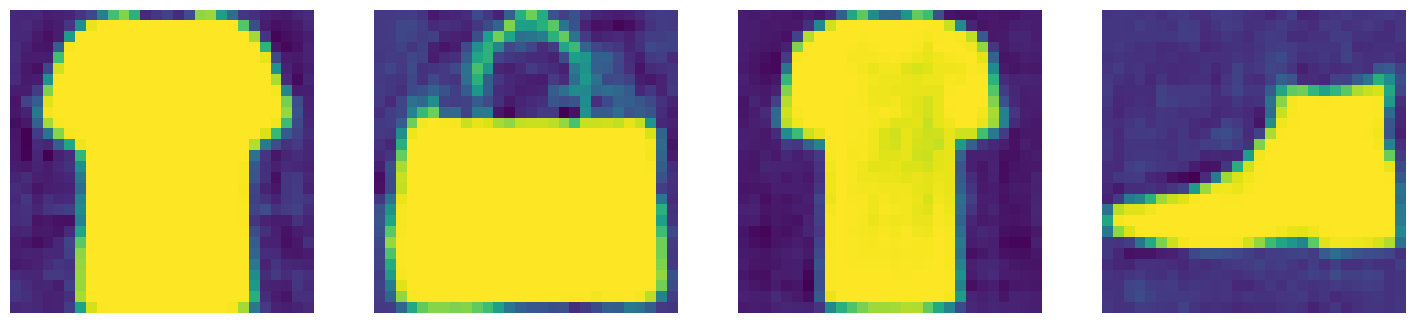

====> Epoch: 39 Average loss: 402.5869
====> Test set loss: 396.1434


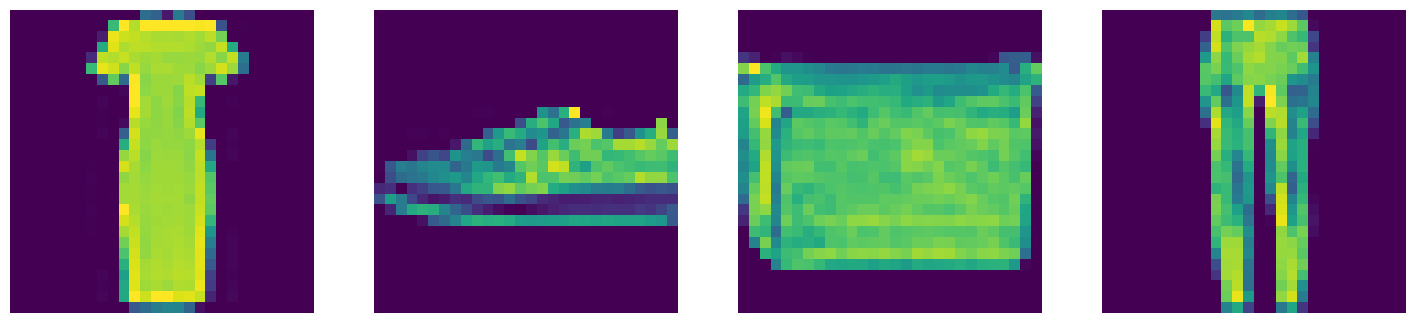

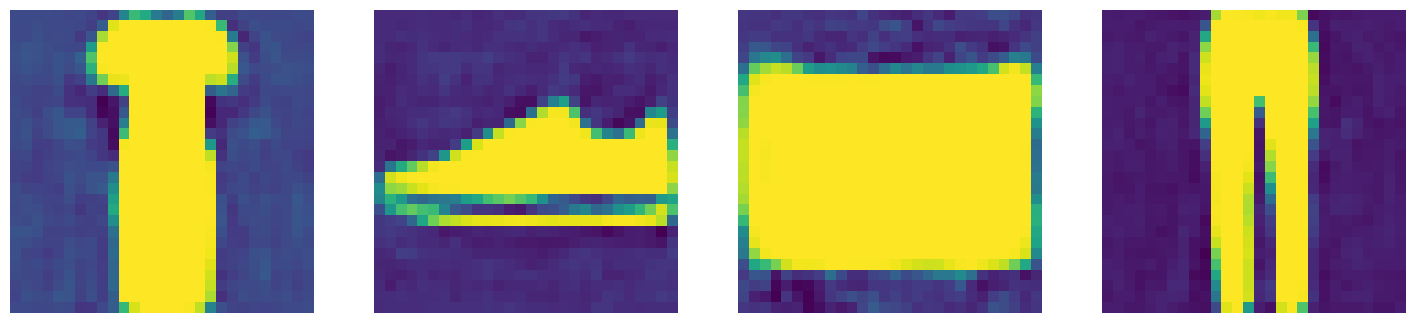

====> Epoch: 40 Average loss: 402.4555
====> Test set loss: 395.0602


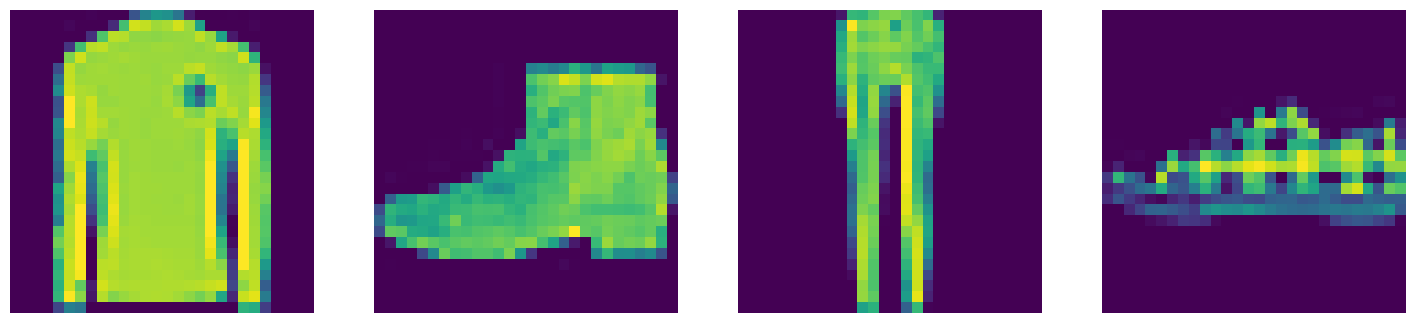

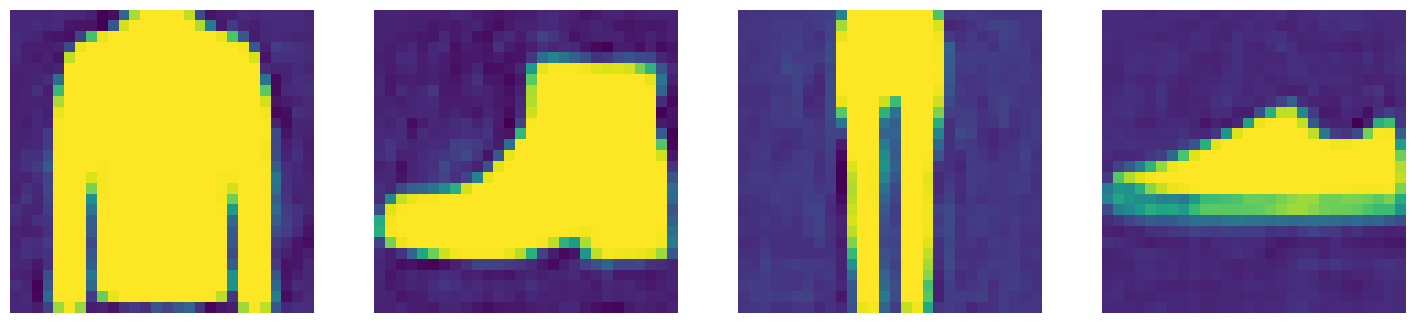

====> Epoch: 41 Average loss: 402.5228
====> Test set loss: 396.0477


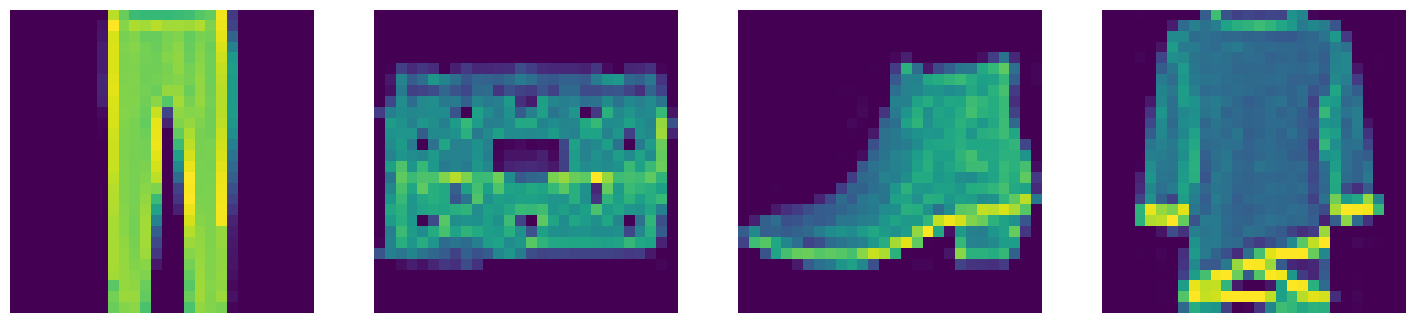

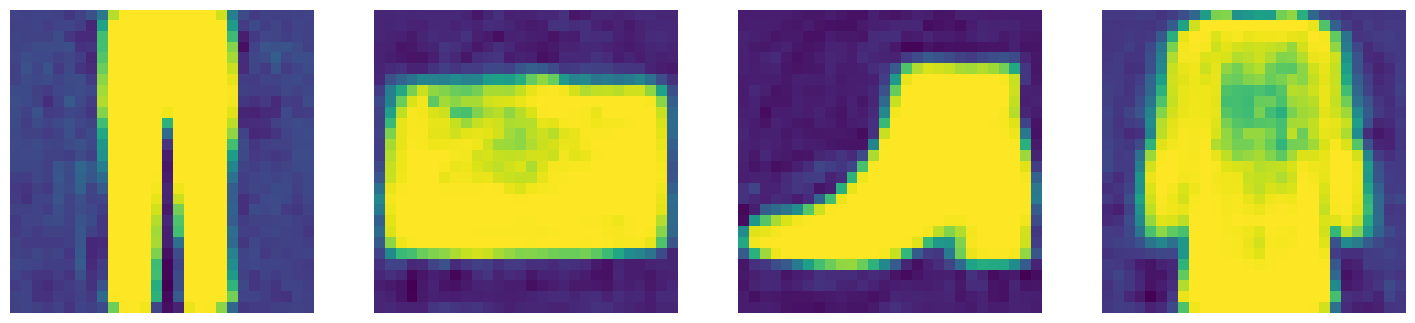

====> Epoch: 42 Average loss: 402.3866
====> Test set loss: 394.3289


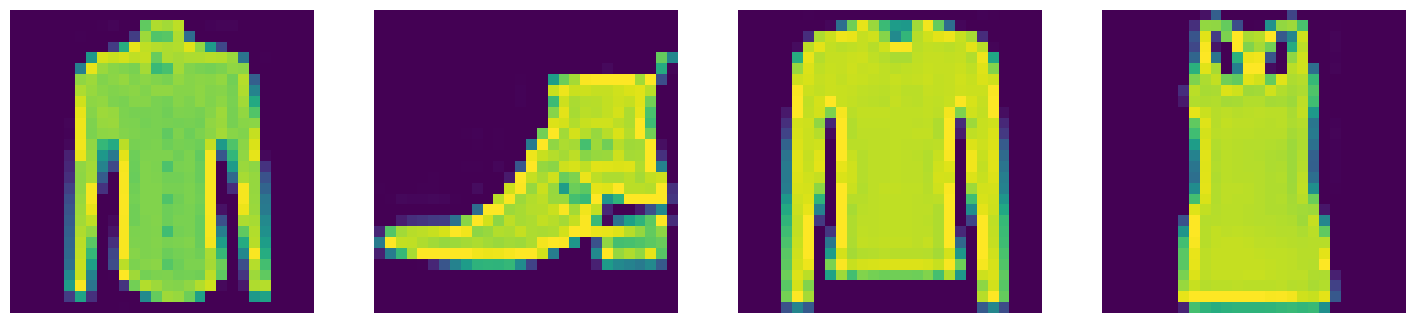

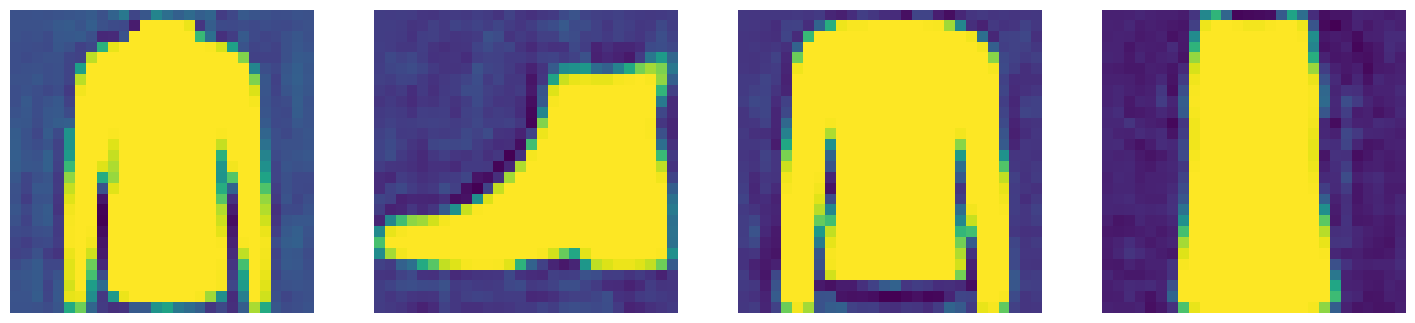

====> Epoch: 43 Average loss: 402.2440
====> Test set loss: 396.3090


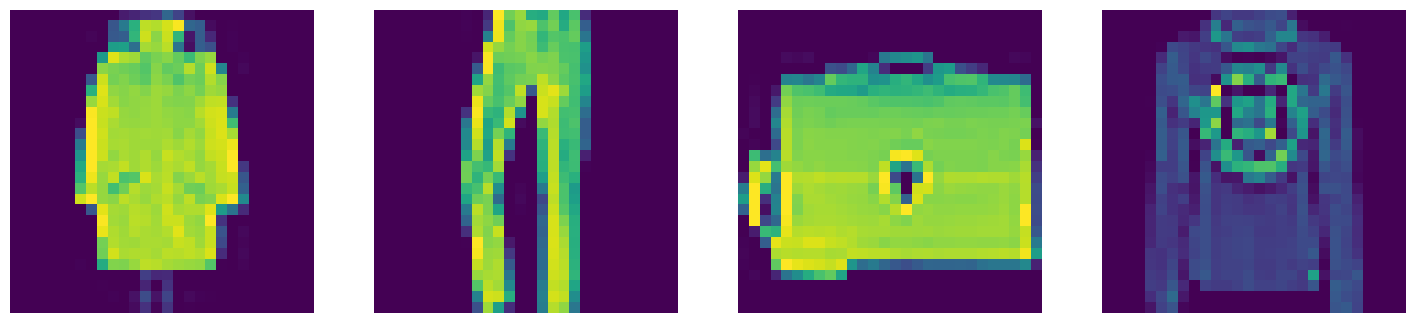

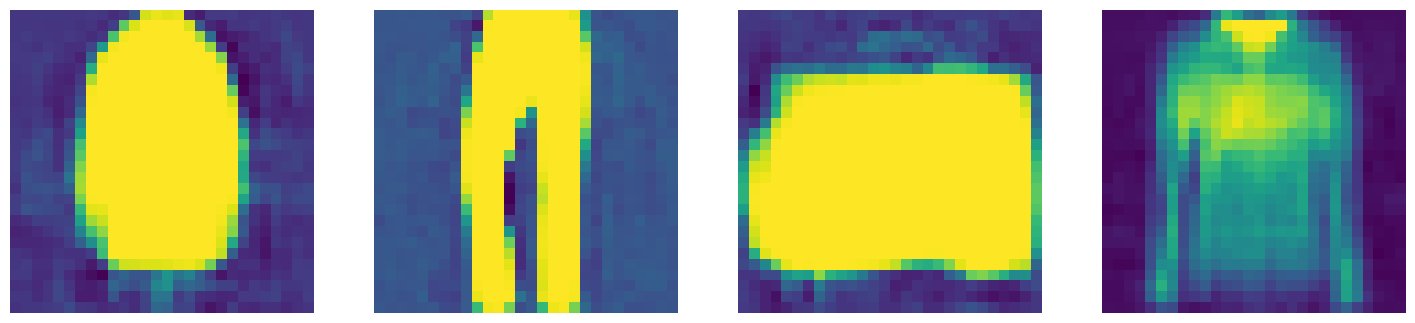

====> Epoch: 44 Average loss: 402.3123
====> Test set loss: 394.8185


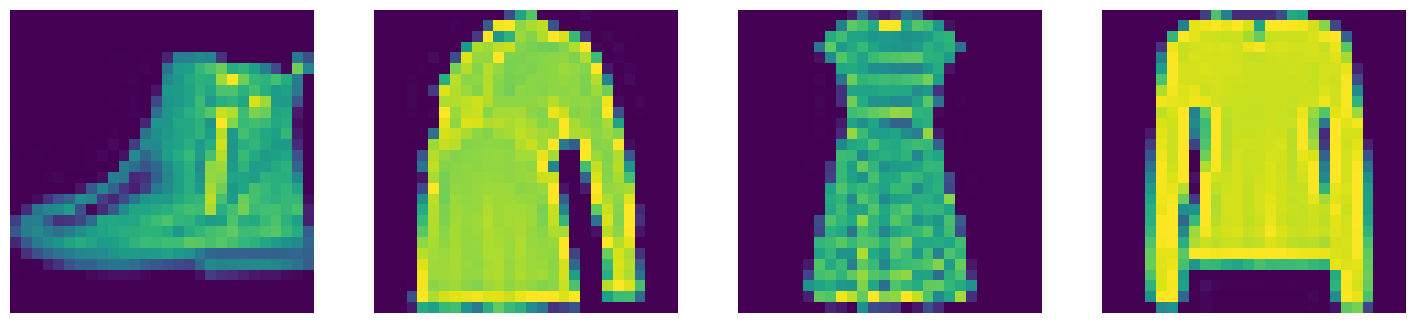

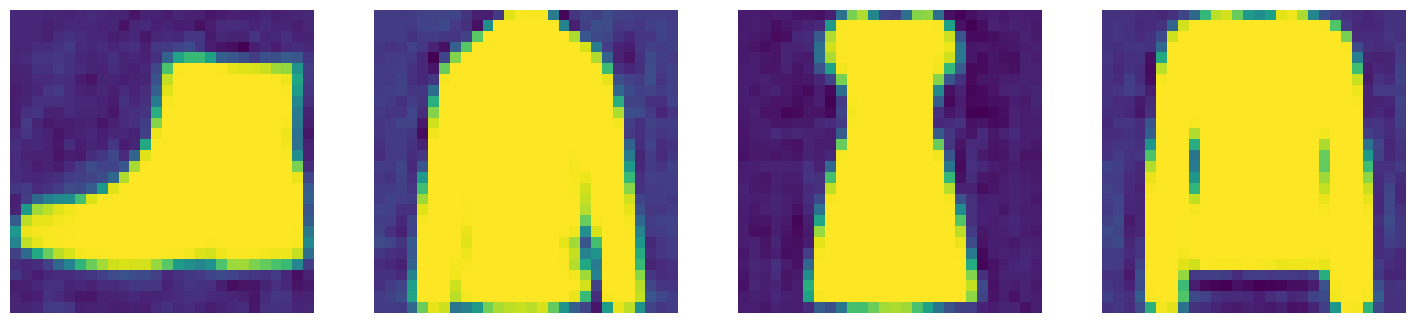

====> Epoch: 45 Average loss: 402.2490
====> Test set loss: 395.3093


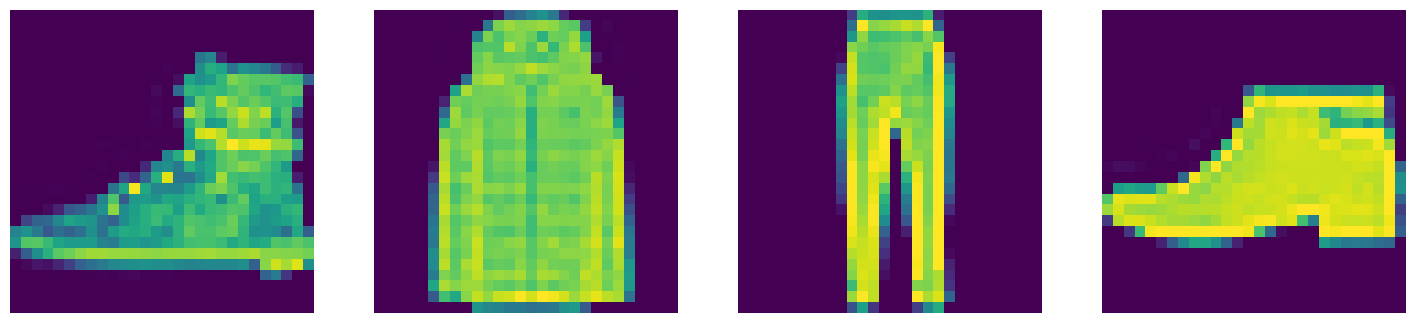

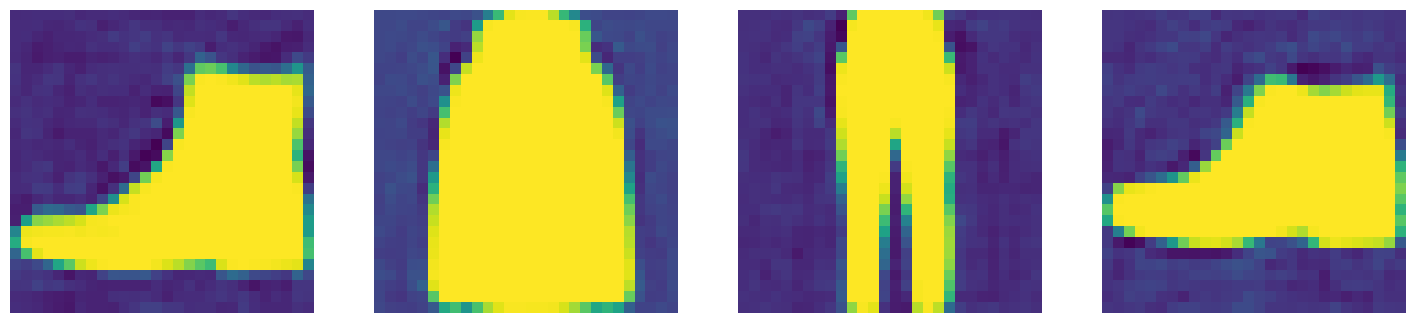

====> Epoch: 46 Average loss: 402.1670
====> Test set loss: 394.8916


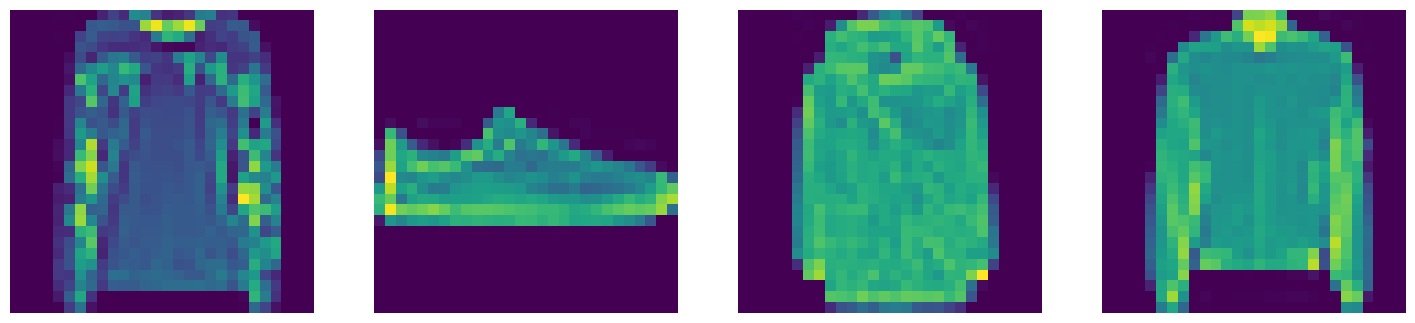

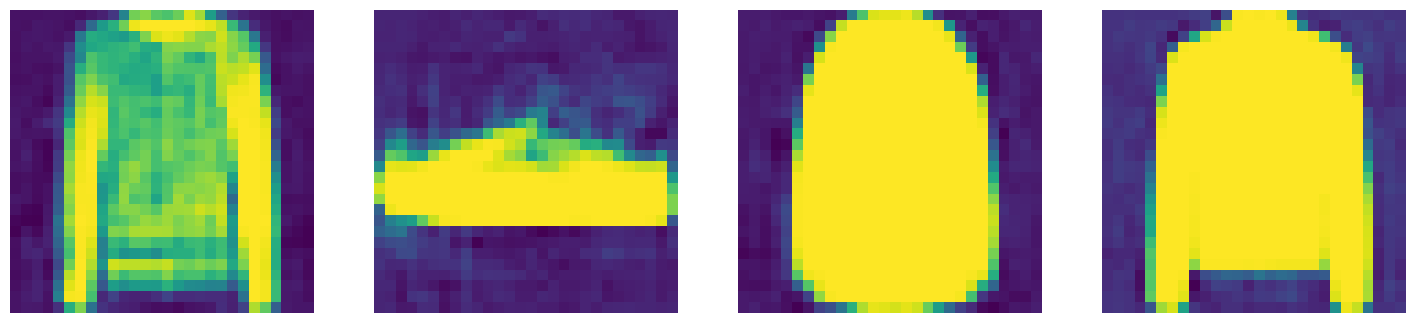

====> Epoch: 47 Average loss: 402.1219
====> Test set loss: 395.1163


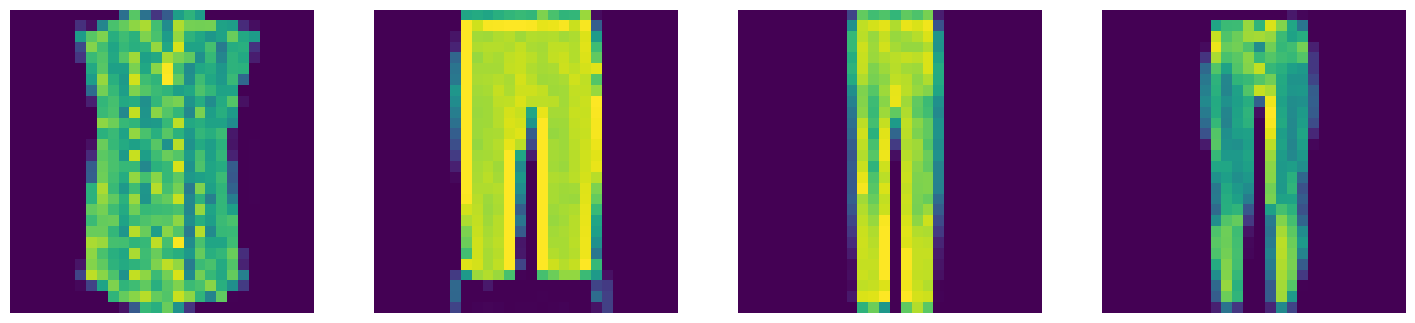

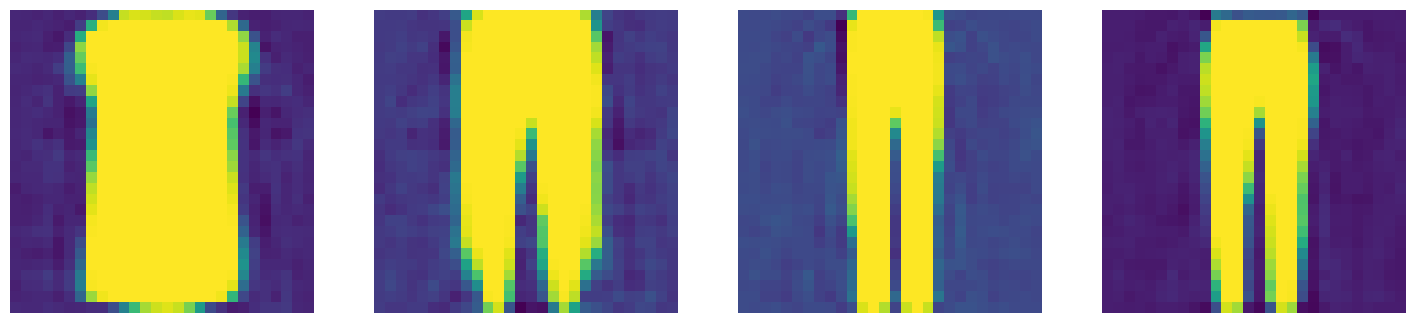

====> Epoch: 48 Average loss: 402.0911
====> Test set loss: 394.9214


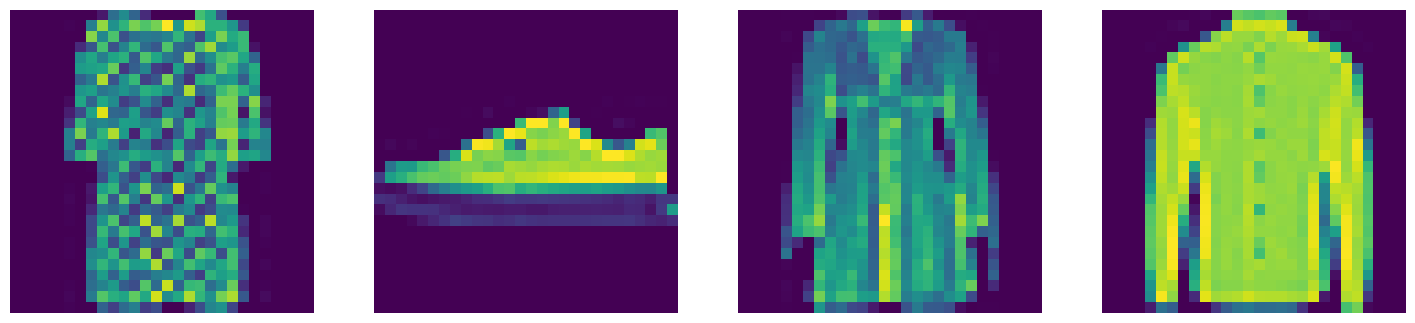

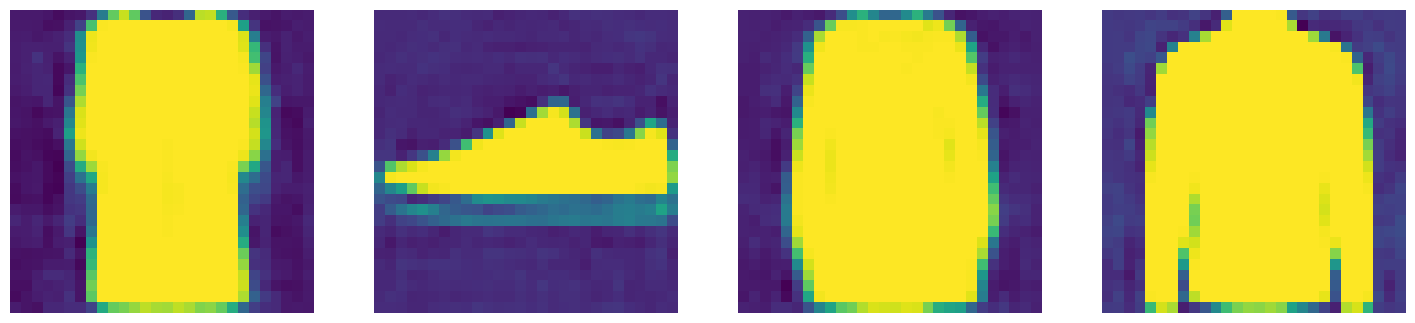

====> Epoch: 49 Average loss: 402.0639
====> Test set loss: 394.9433


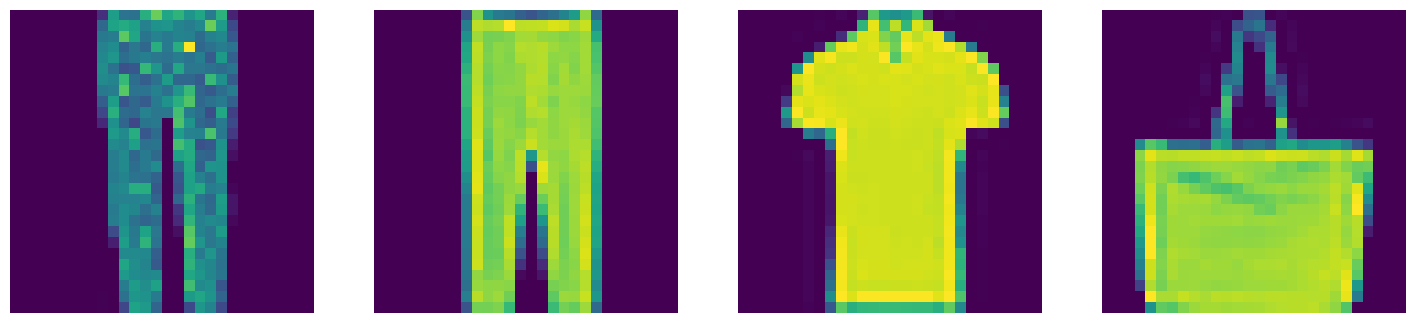

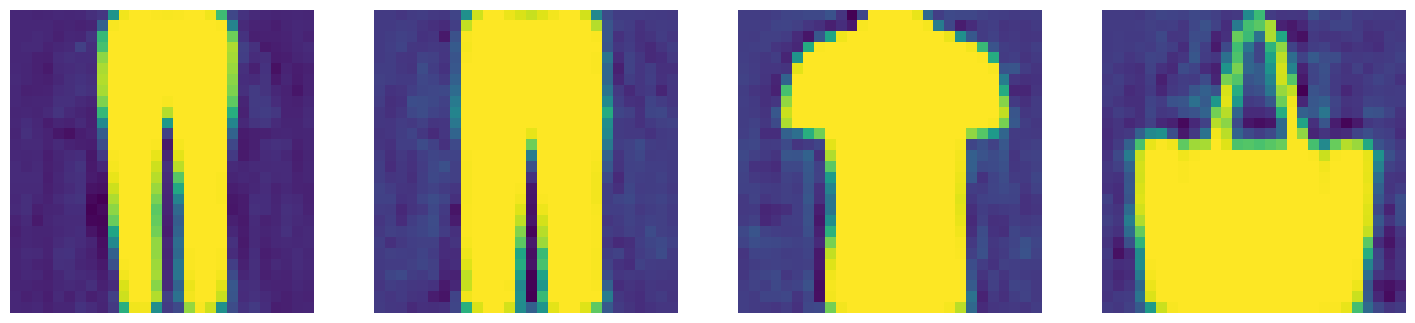

====> Epoch: 50 Average loss: 402.0120
====> Test set loss: 395.5008


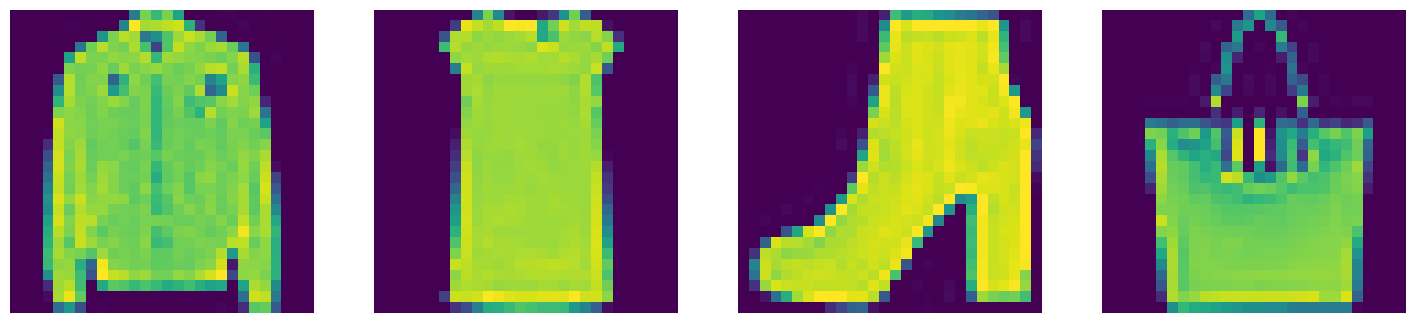

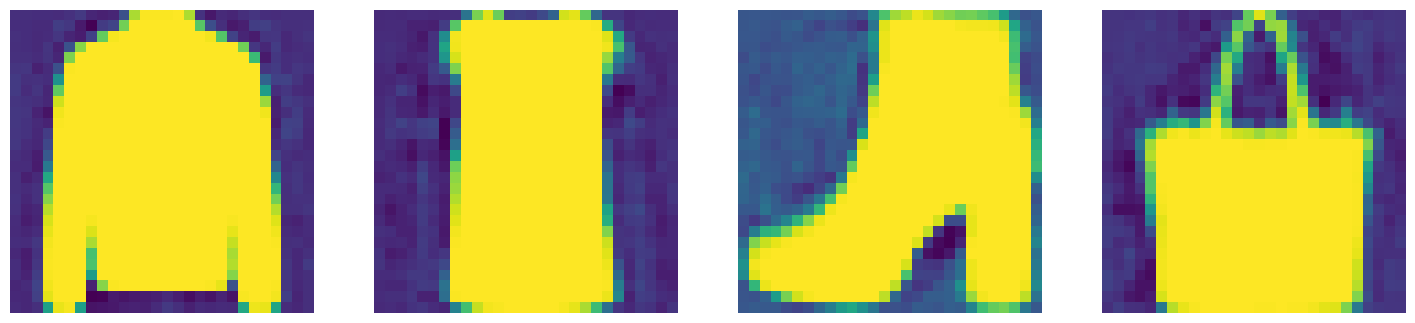

In [ ]:
latent_dim=20
model = VAE(latent_dim).to(device)

# Setting the optimiser
learning_rate = 1e-3
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

epochs = 50
codes = dict(mu=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

    # Testing
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['mu'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 4)

In [ ]:
torch.save(model.state_dict(), 'VAE_Fashion.pth')

## 5 examples of images produced by random samples from the latent space

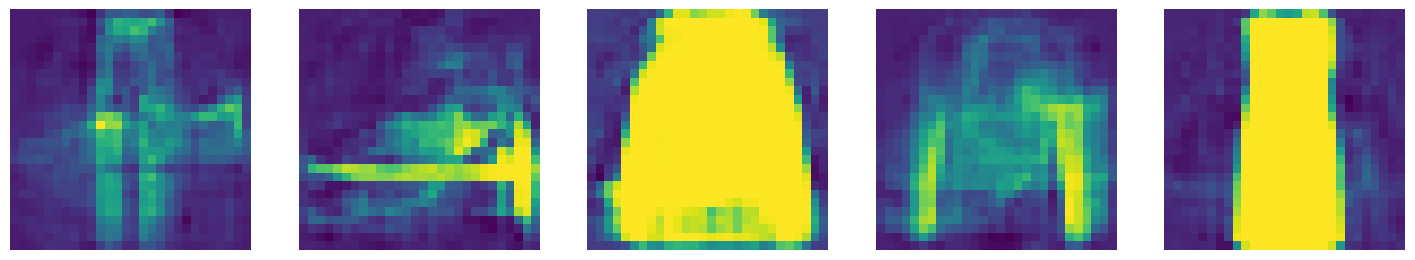

In [ ]:
N=5
display_images(None, model.generate(N), N)

## Interpolation Between 2 images

Example0


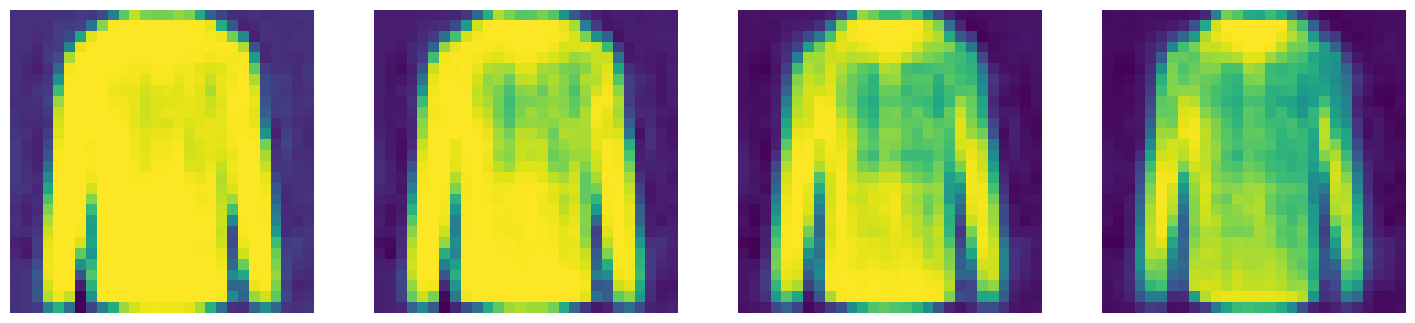

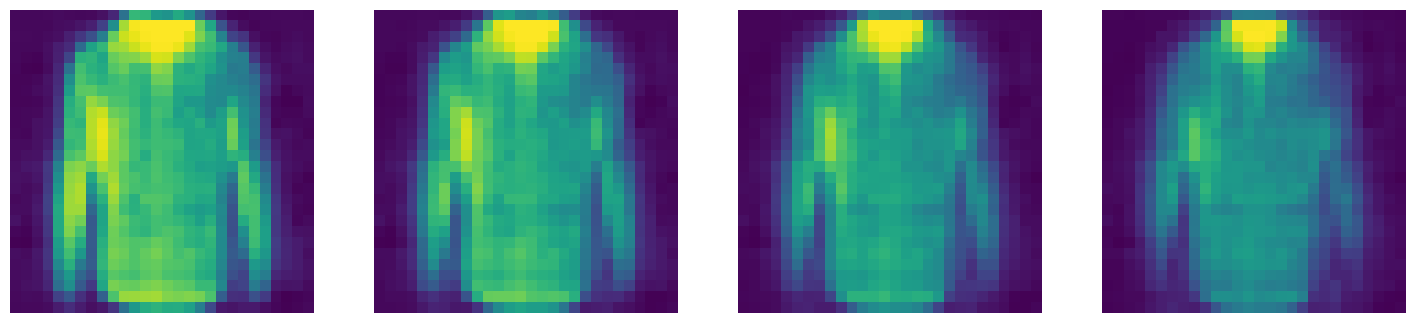

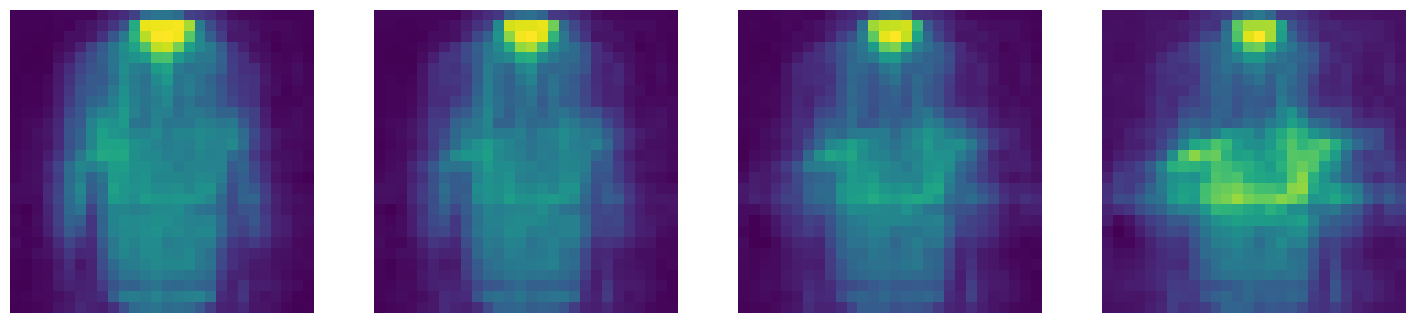

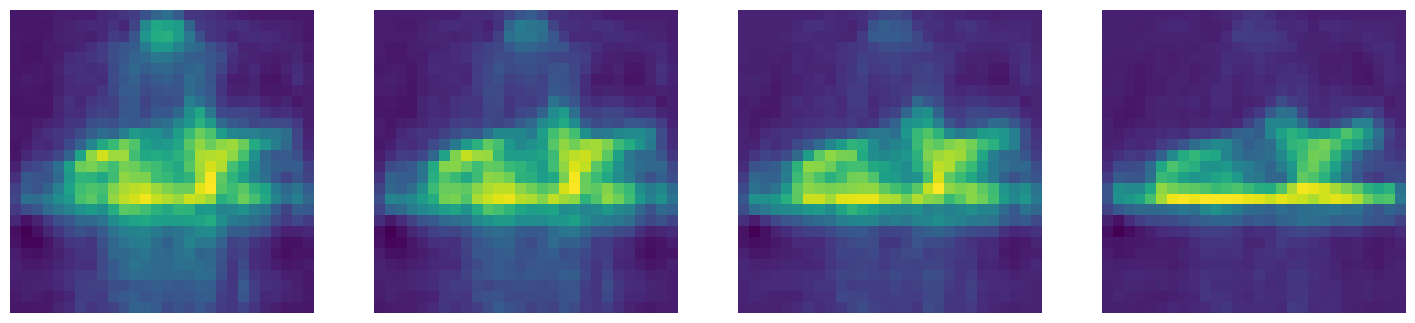

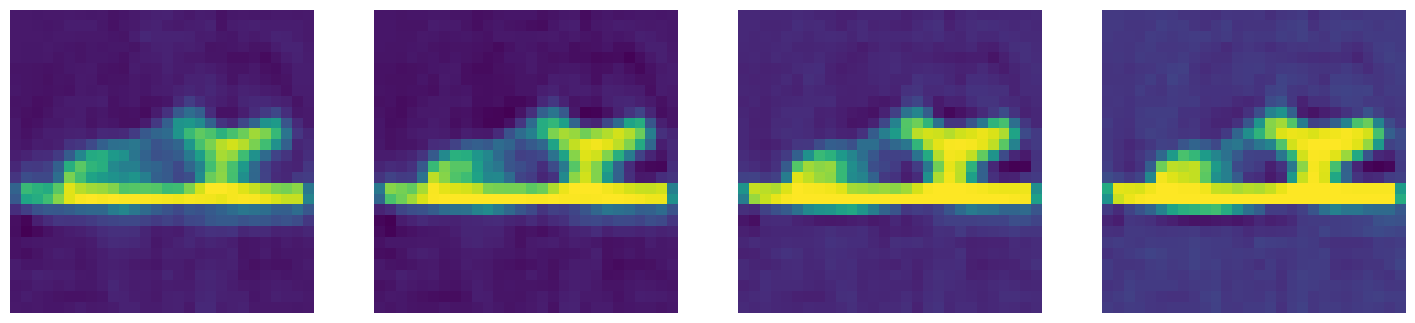

Example1


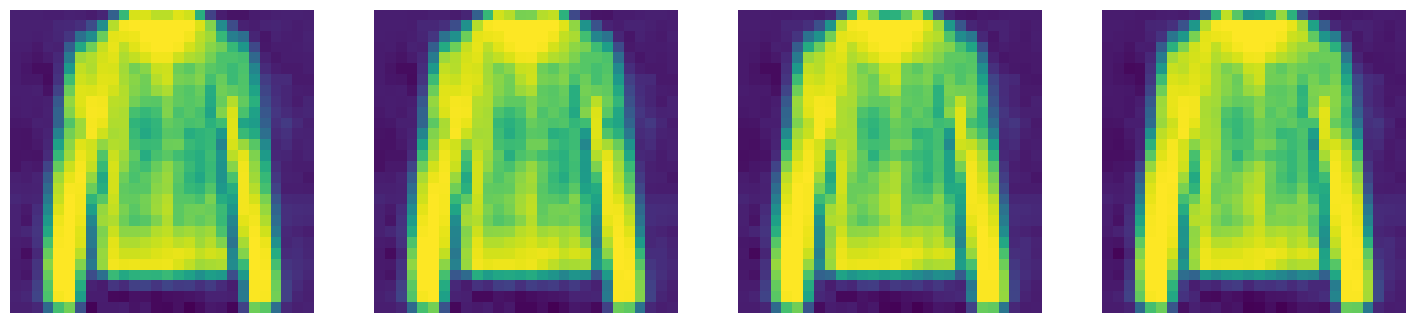

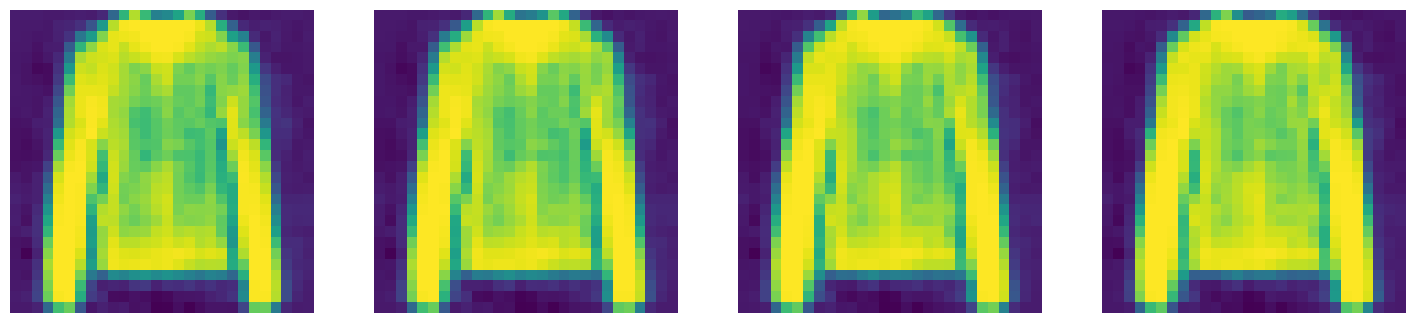

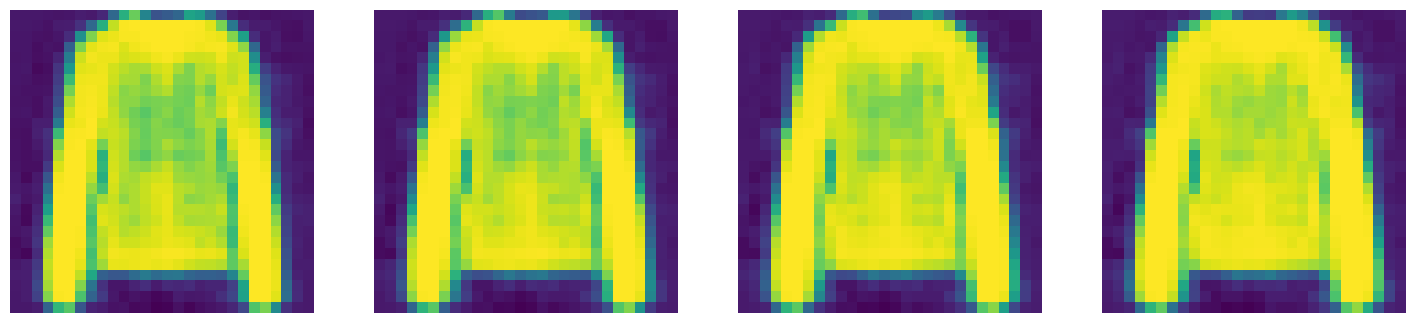

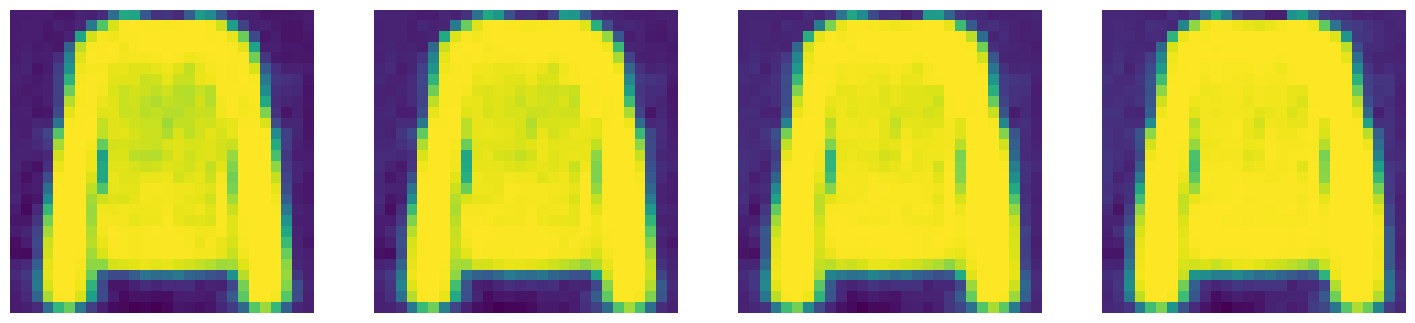

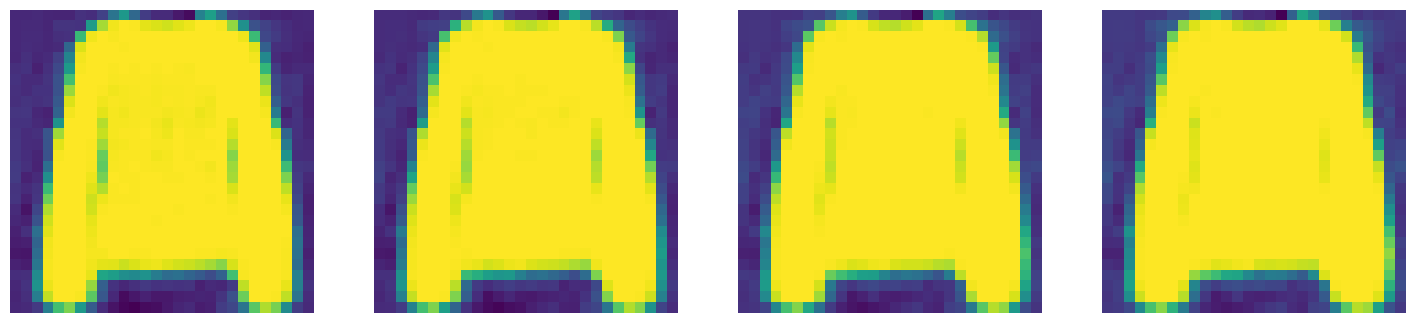

Example2


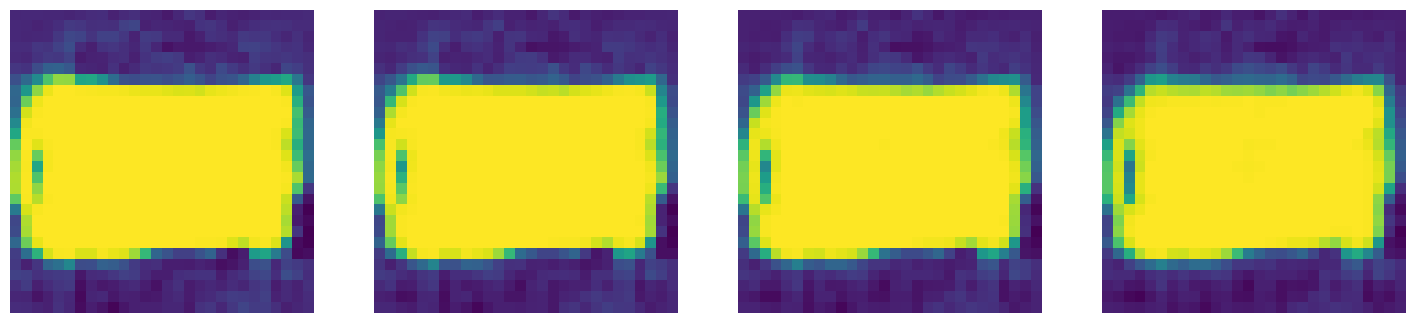

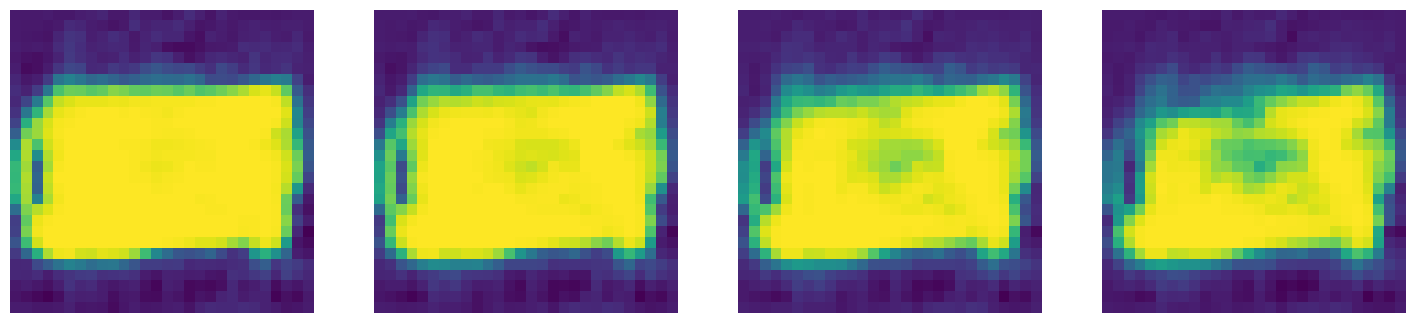

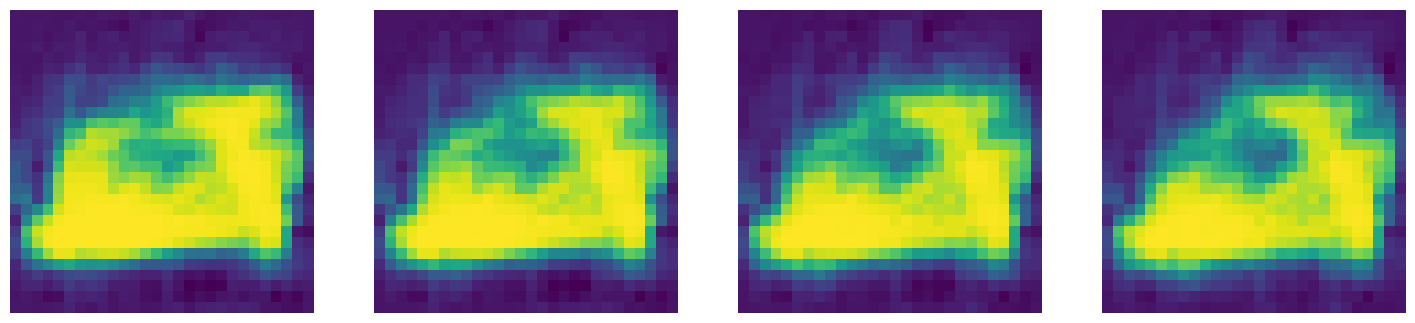

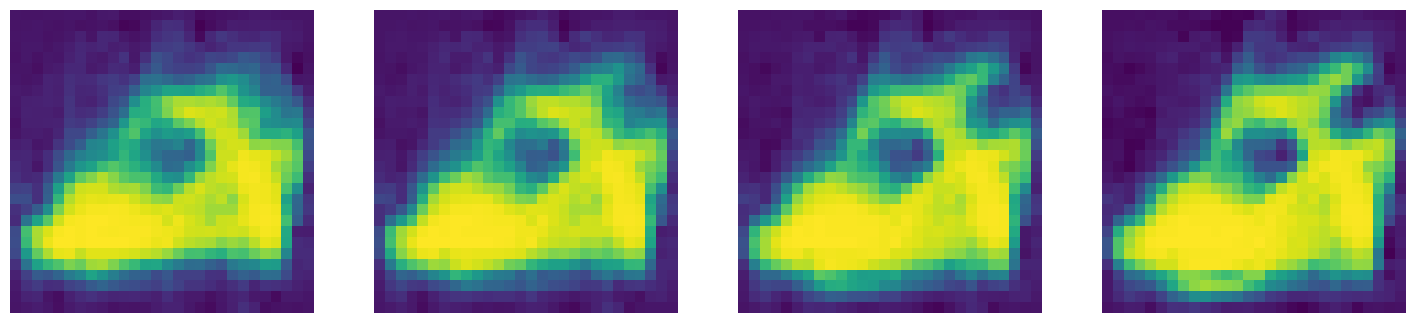

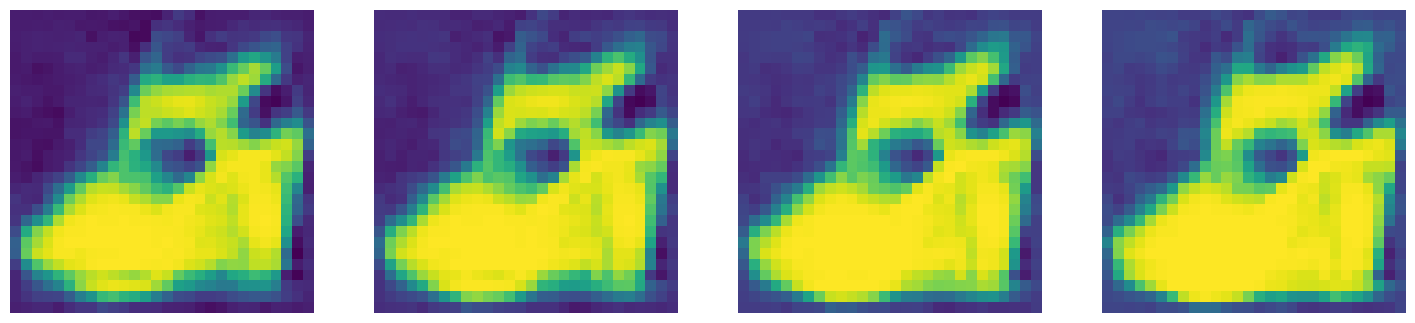

Example3


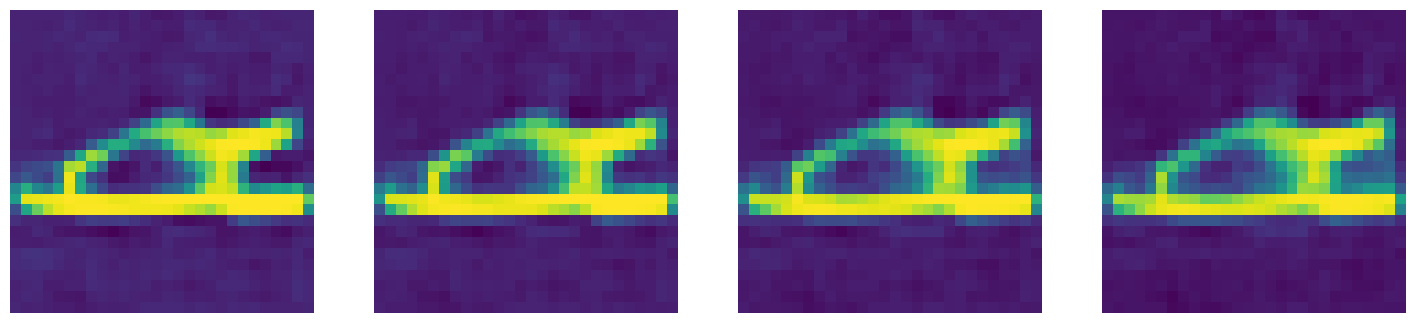

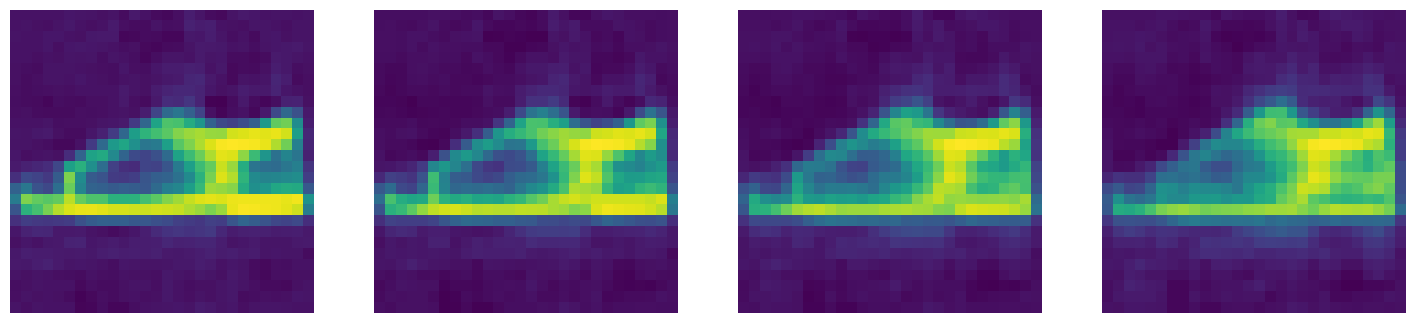

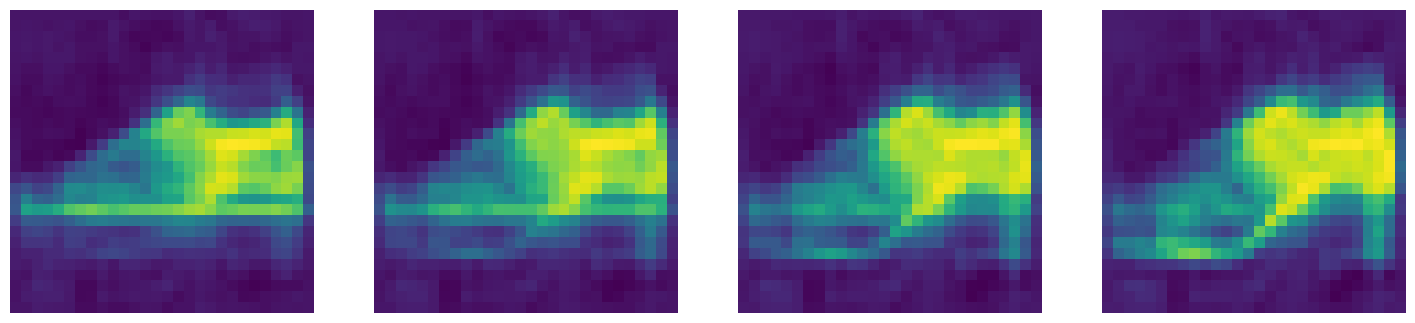

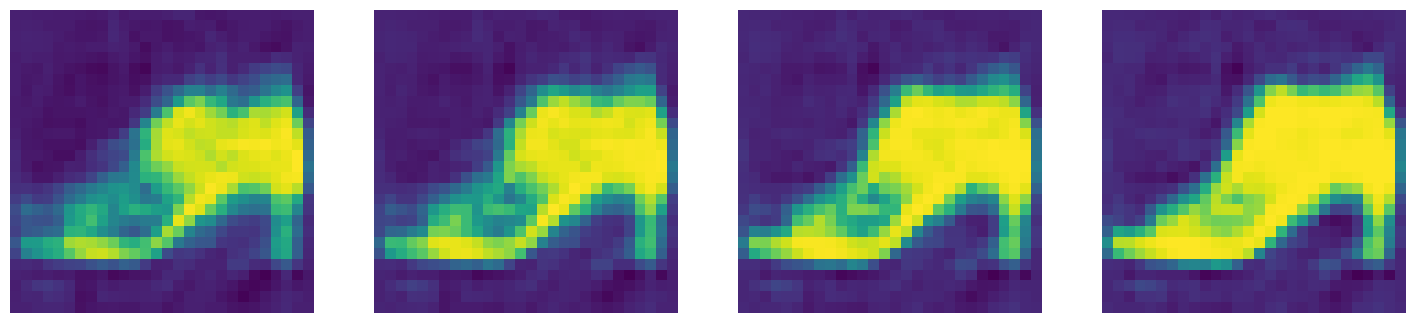

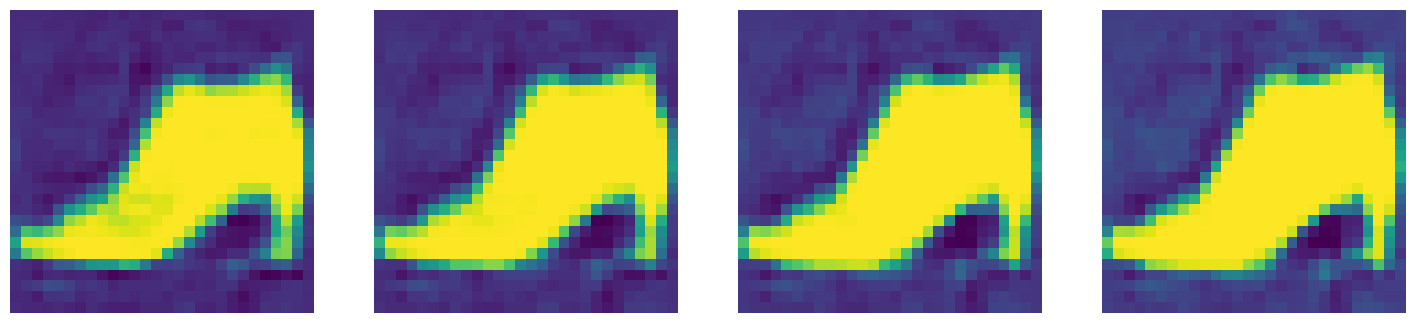

Example4


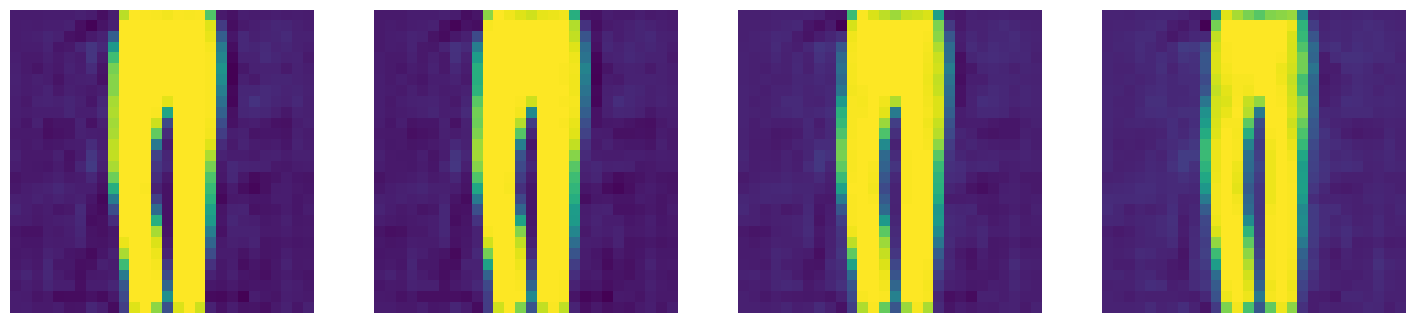

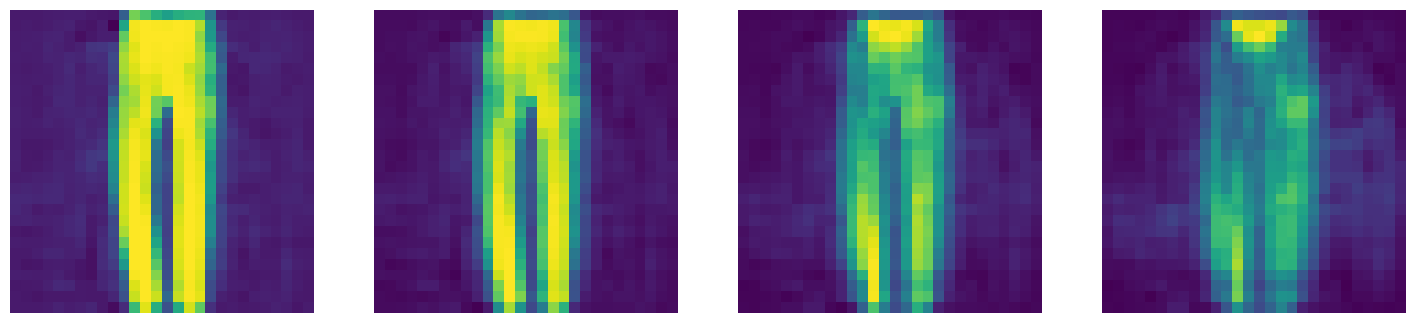

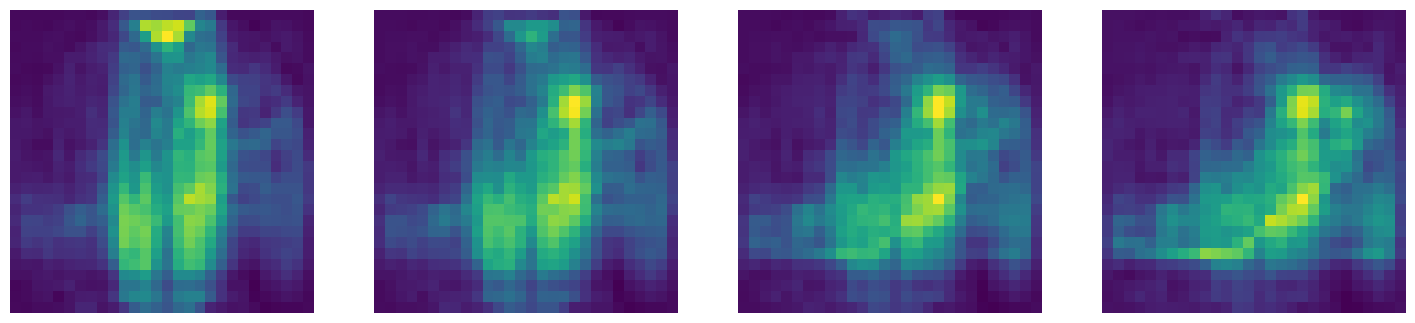

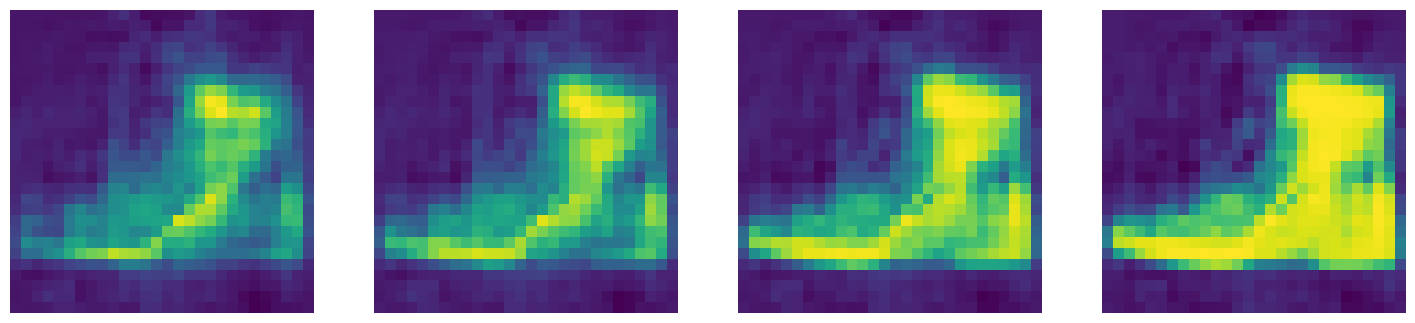

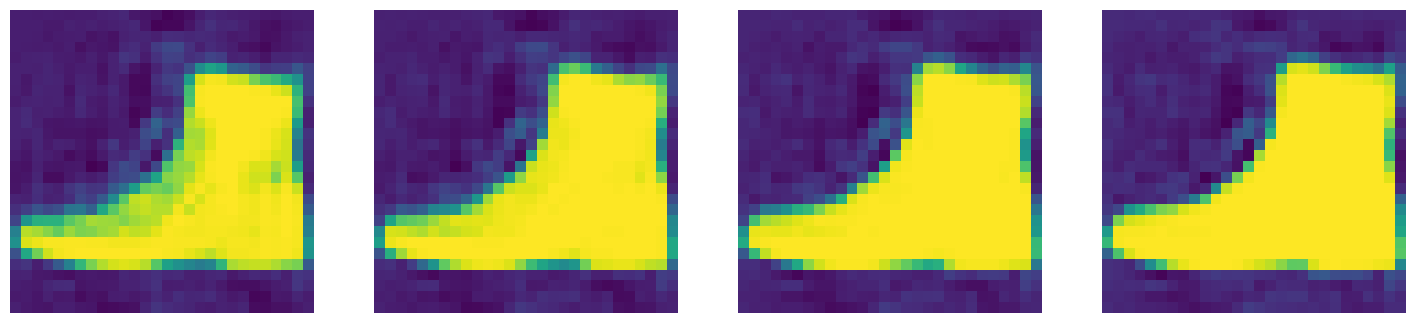

In [ ]:
for i in range(5):
    print(f"Example{i}")
    x, _ = next(iter(test_loader))
    x = x.to(device)
    x_hat, mu, logvar = model(x)
    A, B = 1, 14
    sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
    #sample = torch.stack((x_hat[A].data, x_hat[B].data), 0)
    #display_images(None, torch.stack(((
    #    x[A].data.view(-1),
    #    x[B].data.view(-1)
    #)), 0), 2)
    #display_images(None, torch.stack(((
    #    sample.data[0],
    #    sample.data[1]
    #)), 0), 2)
    # Perform an interpolation between input A and B, in N steps
    N = 20
    code = torch.Tensor(N, latent_dim).to(device)
    sample = torch.Tensor(N, 28, 28).to(device)
    for i in range(N):
        code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
        # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
    img_set = model.decoder(code)
    for i in range(N//4):
        display_images(None, img_set[i*4:4*(i+1)], 4)



# Part 2: GAN for MNIST

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

from PIL import Image
from IPython.display import display
import cv2


import glob
import os
import random
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
transform_img = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor()
    ])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transform_img),
    batch_size=64, shuffle=True)

#test_loader = torch.utils.data.DataLoader(
#    datasets.MNIST('../data', train=False, transform=transforms.Compose([
#                       transforms.ToTensor(),
#                       transforms.Normalize((0.1307,), (0.3081,))
#                   ])),
#    batch_size=1000, shuffle=True)
classNames = [0,1,2,3,4,5,6,7,8,9]

100%|██████████| 9912422/9912422 [00:00<00:00, 96106813.11it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 27350574.36it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28789104.41it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15252625.11it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
def scale_images(x, max = 1.00 , min = -1.00):
    x = x * (max - min) + min
    return x

In [ ]:
'''
The inputs to the discriminator are 32x32x3 tensor images
The output would be a single value that will indicate whether a given image is real or fake
'''
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True, bias = False):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                           kernel_size=kernel_size, stride=stride, padding=padding)
    #appending convolutional layer
    layers.append(conv_layer)
    #appending batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initializing the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer based on which we will create the  next ones where next  layer depth = 2 * previous layer depth
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim


        self.conv1 = conv(1, conv_dim, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2)
        self.conv3 = conv(conv_dim*2, conv_dim*4)
        self.conv4 = conv(conv_dim*4, conv_dim*8)
        self.fc = nn.Linear(conv_dim*4*4*2, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)

        x = x.view(-1, self.conv_dim*4*2*4)

        x = self.fc(x)


        return x

In [ ]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True, bias = False):
    layers = []

    # append transpose conv layer -- we are not using bias terms in conv layers
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))

    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)
class Generator(nn.Module):

    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim

        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        # complete init function

        self.de_conv1 = deconv(conv_dim*4, conv_dim*2)
        self.de_conv2 = deconv(conv_dim*2, conv_dim)
        self.de_conv3 = deconv(conv_dim, 1, 4, batch_norm=False )

        self.dropout = nn.Dropout(0.3)


    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network
        :return: A 32x32x1 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = self.dropout(x)
        x = x.view(-1, self.conv_dim*4, 4, 4)

        x = F.relu(self.de_conv1(x))
        x = F.relu(self.de_conv2(x))
        x = self.de_conv3(x)
        x = F.tanh(x)


        return x

In [ ]:
def weights_init_normal(m):
    """
    :param m: A module or layer in a network
    """
    # like `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__

    #  initial weights to convolutional and linear layers
    if (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal(m.weight.data, 0.0, 0.2)

    if hasattr(m, 'bias') and m.bias is not None:
        nn.init.constant(m.bias.data, 0.0)
# model hyperparameters
d_conv_dim = 64
g_conv_dim = 64
z_size = 100
# building discriminator and generator from the classes defined above
discriminator = Discriminator(d_conv_dim)
generator = Generator(z_size=z_size, conv_dim=g_conv_dim)

# initialize model weights
discriminator.apply(weights_init_normal)
generator.apply(weights_init_normal)
print("done")


done


In [ ]:
print(generator)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (de_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (de_conv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (de_conv3): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (dropout): Dropout(p=0.3, inplace=False)
)


In [ ]:
use_gpu = torch.cuda.is_available()

lr = 0.0002 #learning rate
beta1=0.5
beta2=0.999

# optimizers for the discriminator D and generator G
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr, (beta1, beta2)) # for discriminator
generator_optimizer = torch.optim.Adam(generator.parameters(), lr, (beta1, beta2))

def real_loss(D_out, smooth = False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)

    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)

    if use_gpu:
        labels = labels.cuda()

    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)

    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)

    if use_gpu:
        labels = labels.cuda()

    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)

    return loss

In [ ]:

def train(D, G, n_epochs, train_on_gpu, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''

    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()

    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(train_loader):

            batch_size = real_images.size(0)
            real_images = scale_images(real_images)

            # Train the discriminator on real and fake images
            discriminator_optimizer.zero_grad()

            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)      # Calculates log(D(x))

            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()

            if train_on_gpu:
                z = z.cuda()

            fake_images = G(z)

            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)


            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            discriminator_optimizer.step()

            # 2. Train the generator with an adversarial loss
            generator_optimizer.zero_grad()

            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()

            if train_on_gpu:
                z = z.cuda()

            fake_images = G(z)


            D_fake = D(fake_images)

            g_loss = real_loss(D_fake)  # The Generator wishies to minimize the real_loss for it's fake output
                                        # to trick the Discriminator

            g_loss.backward()
            generator_optimizer.step()

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples1.pkl', 'wb') as f:
        pkl.dump(samples, f)

    # finally return losses
    return losses


In [ ]:
n_epochs = 5
losses = train(discriminator, generator, n_epochs=n_epochs, train_on_gpu = use_gpu)


Epoch [    1/    5] | d_loss: 0.0109 | g_loss: 11.9372
Epoch [    1/    5] | d_loss: 0.0171 | g_loss: 11.0537
Epoch [    1/    5] | d_loss: 0.0401 | g_loss: 8.3362
Epoch [    1/    5] | d_loss: 0.0232 | g_loss: 10.7534
Epoch [    1/    5] | d_loss: 0.0069 | g_loss: 7.7796
Epoch [    1/    5] | d_loss: 0.0060 | g_loss: 9.7205
Epoch [    1/    5] | d_loss: 0.0344 | g_loss: 5.9580
Epoch [    1/    5] | d_loss: 0.0038 | g_loss: 10.4124
Epoch [    1/    5] | d_loss: 0.0265 | g_loss: 8.2770
Epoch [    1/    5] | d_loss: 0.1075 | g_loss: 11.3347
Epoch [    1/    5] | d_loss: 0.0185 | g_loss: 13.6332
Epoch [    1/    5] | d_loss: 0.0291 | g_loss: 6.1045
Epoch [    1/    5] | d_loss: 0.0753 | g_loss: 6.1375
Epoch [    1/    5] | d_loss: 0.1334 | g_loss: 7.5347
Epoch [    1/    5] | d_loss: 0.0693 | g_loss: 7.5170
Epoch [    1/    5] | d_loss: 0.0317 | g_loss: 4.7839
Epoch [    1/    5] | d_loss: 0.2124 | g_loss: 9.5151
Epoch [    1/    5] | d_loss: 0.0145 | g_loss: 6.8357
Epoch [    1/    5] | 

In [ ]:
torch.save(generator.state_dict(), 'Generator2.pth')
torch.save(discriminator.state_dict(), 'Discriminator2.pth')

In [ ]:
n_epochs = 5
losses = train(discriminator, generator, n_epochs=n_epochs, train_on_gpu = use_gpu)

Epoch [    1/    5] | d_loss: 0.0262 | g_loss: 8.9574
Epoch [    1/    5] | d_loss: 0.0203 | g_loss: 8.6511
Epoch [    1/    5] | d_loss: 0.0378 | g_loss: 6.0347
Epoch [    1/    5] | d_loss: 0.0166 | g_loss: 5.6450
Epoch [    1/    5] | d_loss: 0.0245 | g_loss: 6.0730
Epoch [    1/    5] | d_loss: 0.0360 | g_loss: 5.9836
Epoch [    1/    5] | d_loss: 0.0158 | g_loss: 6.1479
Epoch [    1/    5] | d_loss: 0.0566 | g_loss: 8.8847
Epoch [    1/    5] | d_loss: 0.0489 | g_loss: 5.2653
Epoch [    1/    5] | d_loss: 0.0343 | g_loss: 8.3643
Epoch [    1/    5] | d_loss: 0.0167 | g_loss: 4.6850
Epoch [    1/    5] | d_loss: 0.0458 | g_loss: 5.8606
Epoch [    1/    5] | d_loss: 0.0088 | g_loss: 7.8661
Epoch [    1/    5] | d_loss: 0.0321 | g_loss: 6.7346
Epoch [    1/    5] | d_loss: 0.0122 | g_loss: 7.4985
Epoch [    1/    5] | d_loss: 0.0584 | g_loss: 6.8052
Epoch [    1/    5] | d_loss: 0.0092 | g_loss: 5.0376
Epoch [    1/    5] | d_loss: 0.0258 | g_loss: 8.0478
Epoch [    1/    5] | d_loss

In [ ]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(12,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        im = ax.imshow(img.reshape((32,32)))




## Part A

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open('/content/drive/MyDrive/Coursework/AML/train_samples1.pkl', 'rb') as f:
    samples = pkl.load(f)



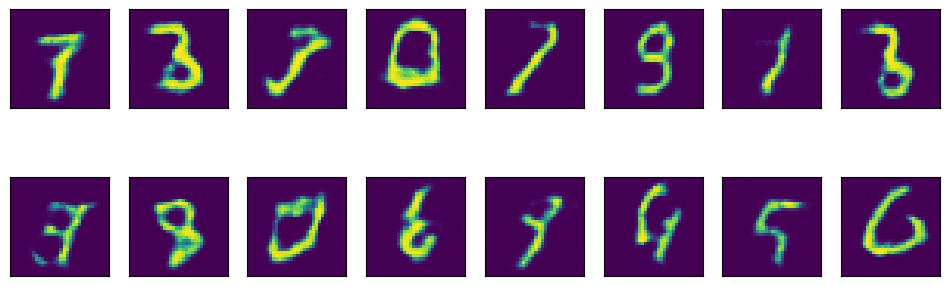

In [ ]:
_ = view_samples(-1, samples)

## Part B


In [ ]:
generator.load_state_dict(torch.load('/content/drive/MyDrive/Coursework/AML/Generator2.pth'))
generator.eval()

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (de_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (de_conv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (de_conv3): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (dropout): Dropout(p=0.3, inplace=False)
)

Example: 1


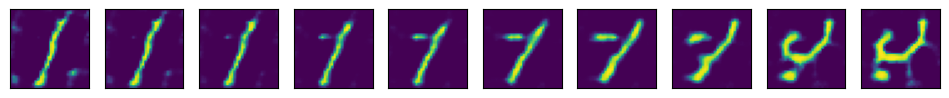

Example: 2


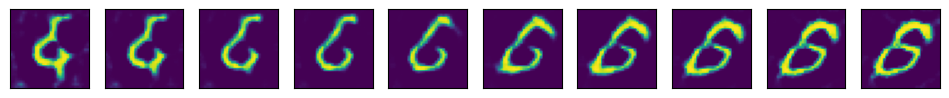

Example: 3


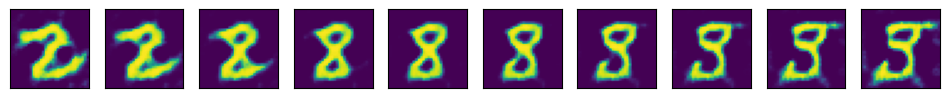

Example: 4


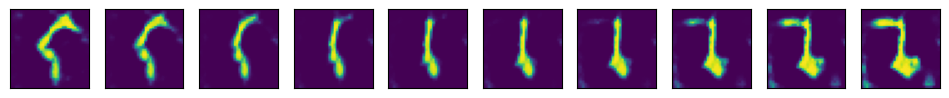

Example: 5


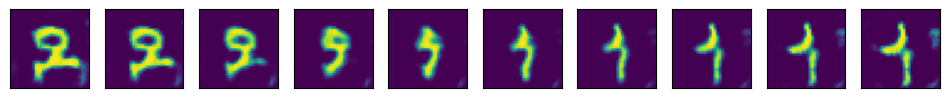

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def view_samples(samples, example):
    fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=10, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        img = img.detach().cpu().numpy()
        img = ((img + 1) * 255 / 2).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.imshow(img.reshape((32, 32)))



for example in range(5):
    # Pick two random codewords 'a' and 'b'
    a = torch.randn(1, 100)  # Assuming the latent vector size is 100
    b = torch.randn(1, 100)

    # Calculate 10 uniformly spaced points between 'a' and 'b'
    interpolation_points = []
    for t in np.linspace(0, 1, 10):
        point = a + t * (b - a)
        interpolation_points.append(point)

    # Generate images from the interpolation points
    images = []
    for point in interpolation_points:
        with torch.no_grad():
            generated_image = generator(point)
        images.append(generated_image)

    print("Example:", example+1)
    view_samples(images, example)
    plt.show()  # Show the figure for each example


# Part 3: Conditional GAN for MNIST

In [1]:


%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder, MNIST
from torchvision import transforms
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid

!pip install tensorboardX
from tensorboardX import SummaryWriter


writer = SummaryWriter()



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.4 MB/s eta 0:00:00


In [2]:


transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])

batch_size = 32
data_loader = torch.utils.data.DataLoader(MNIST('data', train=True, download=True, transform=transform),
                                          batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 88137352.52it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 84415117.65it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 13187142.52it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15615187.51it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [4]:


class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)



In [5]:
generator = Generator()
discriminator = Discriminator()



criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)



In [6]:


def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100))
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size)))
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)))
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()



In [7]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)))

    # train with fake images
    z = Variable(torch.randn(batch_size, 100))
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size)))
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)))

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [8]:
num_epochs = 50
n_critic = 5
display_step = 50
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch), end=' ')
    for i, (images, labels) in enumerate(data_loader):

        step = epoch * len(data_loader) + i + 1
        real_images = Variable(images)
        labels = Variable(labels)
        generator.train()

        d_loss = 0
        for _ in range(n_critic):
            d_loss = discriminator_train_step(len(real_images), discriminator,
                                              generator, d_optimizer, criterion,
                                              real_images, labels)


        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

        writer.add_scalars('scalars', {'g_loss': g_loss, 'd_loss': (d_loss / n_critic)}, step)

        if step % display_step == 0:
            generator.eval()
            z = Variable(torch.randn(9, 100))
            labels = Variable(torch.LongTensor(np.arange(9)))
            sample_images = generator(z, labels).unsqueeze(1)
            grid = make_grid(sample_images, nrow=3, normalize=True)
            writer.add_image('sample_image', grid, step)
    print('Done!')



Starting epoch 0... Done!
Starting epoch 1... Done!
Starting epoch 2... Done!
Starting epoch 3... Done!
Starting epoch 4... Done!
Starting epoch 5... Done!
Starting epoch 6... Done!
Starting epoch 7... Done!
Starting epoch 8... Done!
Starting epoch 9... Done!
Starting epoch 10... Done!
Starting epoch 11... Done!
Starting epoch 12... Done!
Starting epoch 13... Done!
Starting epoch 14... Done!
Starting epoch 15... Done!
Starting epoch 16... Done!
Starting epoch 17... Done!
Starting epoch 18... Done!
Starting epoch 19... Done!
Starting epoch 20... Done!
Starting epoch 21... Done!
Starting epoch 22... Done!
Starting epoch 23... Done!
Starting epoch 24... Done!
Starting epoch 25... Done!
Starting epoch 26... Done!
Starting epoch 27... Done!
Starting epoch 28... Done!
Starting epoch 29... Done!
Starting epoch 30... Done!
Starting epoch 31... Done!
Starting epoch 32... Done!
Starting epoch 33... Done!
Starting epoch 34... Done!
Starting epoch 35... Done!
Starting epoch 36... Done!
Starting ep

In [22]:


torch.save(generator.state_dict(), 'generator_state.pt')



z = Variable(torch.randn(40, 100))
labels = torch.LongTensor([i for i in range(4) for _ in range(10)])

In [20]:
z.shape

torch.Size([40, 100])

(-0.5, 301.5, 121.5, -0.5)

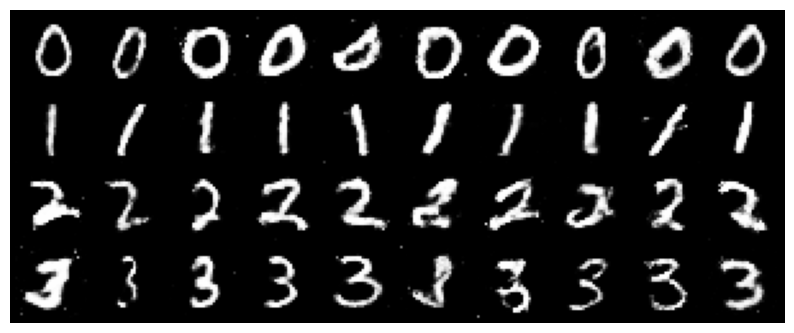

In [23]:


images = generator(z, labels).unsqueeze(1)
grid = make_grid(images, nrow=10, normalize=True)



fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid.permute(1, 2, 0).data, cmap='binary')
ax.axis('off')


